# Inventory Management

## Business Context

is a store that sells various items, a family-owned in Janaúba-MG. The owner of the store is having problems with the inventory management and with the product offerings.

So you were hired as a Data Analyst, and your main challenge is to help the company optimize its inventory and products offerings.

The owner want the answer for the following questions?

1. What is the probablity that will sell X units a day?
3. Given the demand, what is the probability of stock-out if I arrange to have 5 units in stock every day?
4. What is the range which contains 90% of my possible demand?
5. After running a promotion, has the discount improved daily sales?
6. What products should I focus on?


Solution Planning

- Collect the store sales data.
- Run an Exploratory Analysis.
- Find the high-revenues SKUs
- Determine their demand distriburion
- Define for each SKU the carrying 'too much' an carrying too 'little' inventory points.
- Use the demand distribution to answer the questions
- Write a report with the answers for the owner's questions and the lower and upper bound invetory for each SKU.

## Data Dictionary

Attribute|Description
---------|-----------
date| Date of the sale data. There are no holiday efects or store closures
store| Store ID
item| Item ID
sales| Number of items sold at a particular store on a particular date.

## 0.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import streamlit as st
import scipy.stats as sp
import statsmodels.api as stat
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung

In [2]:
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (25, 8)
plt.rcParams['font.size'] = 17

## 0.2 Helper Functions

In [3]:
# General Functions
def num_summary(df):

    summary = df.agg(['min', 'median','mean', 'max', 'ptp', 'var', 'std', 'kurtosis', 'skew']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})
    summary['25th'] = np.quantile(df, 0.25, axis=0)
    summary['75th'] = np.quantile(df, 0.75, axis=0)

    return summary[['attributes', 'min', '25th', 'median', 'mean', '75th', 'max', 'range', 'var', 'std', 'kurtosis', 'skew']]


def hist_box(data: pd.DataFrame, attribute, product, bins=50, ):

    plt.subplot(1, 2, 1)
    plt.title(f'Item {product} {attribute.capitalize()} - Histogram')
    data[attribute].hist(bins=bins, density=True)
    data[attribute].plot(kind='kde')
    plt.subplot(1, 2, 2)
    plt.title(f'Item {product} {attribute.capitalize()} - BoxPlot')
    data[attribute].plot(kind='box', vert=False,);


def hist_means(samples, product, bins=50):
    
    sns.histplot(samples, kde=True, bins=50)
    plt.title(f'CLT - Item {product} - Distribution of means');


def test_normality(data):

    score, p_value = sp.normaltest(data)
    print(f'p-value: {p_value:.4f}')
    
    if p_value < 0.05:
        print('Reject the null Hypothesis. We can\'t say it is normal distributed')
    else:
        print('Fail to reject the null Hypothesis. We can\'t say the data it is not normal distributed')

# Product Demand Analysis       
def prod_daily_sales(data, product, target, date_col):

    df_sales = data.query(f'item == {product}').sort_values(date_col)
    df_daily_sales = df_sales.groupby(date_col).sum()[[target]]


    return df_daily_sales


def probability_sale_at_least(target, mean, st_dev):

    assert isinstance(target, float) or isinstance(target, int), '`target` must be a float or int.'
    assert isinstance(mean, float) or isinstance(mean, int), '`mean` must be a float.'
    assert isinstance(st_dev, float) or isinstance(st_dev, int), '`st_dev` must be a float.'

    z_score = (target - mean)/st_dev
    prob = 1 - sp.norm.cdf(z_score)
    #prob_ = 1-sp.norm.cdf(target, loc=mean, scale=st_dev)

    return prob


def sampling(data, n_samples, sample_size, attribute='sales', seed=12):

    """This function receives a data set and returns `n_samples` with `sample_size` elements each for a given `attribute` and the means of each sample."""

    assert isinstance(data, pd.DataFrame), "`data` Must be a PandasDataFrame."

    np.random.seed(seed)
    samples = []

    for i in range(n_samples):

        #samples_mean.append(daily_sales.sample(30)['sales'].mean())
        samples.append(data.sample(sample_size)[attribute])

    samples_means = np.mean(samples, axis=1)

    return samples, samples_means
    #sns.histplot(samples_means, kde=True, bins=50);


def interval_perc(mean, st_dev, percent=0.9):

    upper = 1 - (1 - percent)/2
    lower = (1 - percent)/2
    upper_limit = sp.norm.ppf(upper, loc=mean, scale=st_dev)
    lower_limit = sp.norm.ppf(lower, loc=mean, scale=st_dev)

    print(f'Range with {percent:.2%} of possible demand:\nLower Limit  ——— Upper Limit\n     [{round(lower_limit)}    ———    {round(upper_limit)}]')

    return lower_limit, upper_limit


def stocking_out_value(mean, st_dev, percent=0.8):

    value = sp.norm.ppf(1-percent, loc=mean, scale=st_dev)

    #print(f'')
    return round(value)

## 0.3 Load Data

In [4]:
types = {'store': np.uint16, 'item': np.uint16, 'sales': np.uint32}
data = pd.read_csv('../DATA/train.csv',low_memory=True, dtype=types, parse_dates=['date'])

In [5]:
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# 1.0 Data Description

In [6]:
df_desc = data.copy()

## 1.1 Data Dimension

In [7]:
print(f'Number of rows: {df_desc.shape[0]}')
print(f'Number of columns: {df_desc.shape[1]}')

Number of rows: 913000
Number of columns: 4


## 1.2 Data Types

In [8]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  uint16        
 2   item    913000 non-null  uint16        
 3   sales   913000 non-null  uint32        
dtypes: datetime64[ns](1), uint16(2), uint32(1)
memory usage: 13.9 MB


## 1.3 Missing Values

In [9]:
df_desc.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

### 1.3.1 Handling Missing vlaues

In [10]:
# There are no missing values in the dataset

## 1.4 Duplicates

### 1.4.1 Handling Duplicates

In [11]:
df_desc.duplicated().sum()

0

No duplicates in our data.

## 1.5 Numerical Attributes

In [12]:
num_att = df_desc.select_dtypes(include=[float, np.uint32, np.uint16])

num_summary(num_att)

,attributes,min,25th,median,mean,75th,max,range,var,std,kurtosis,skew
0,store,1.0,3.0,5.5,5.500000,8.0,10.0,9.0,8.250009,2.872283,-1.224243,0.000000
1,item,1.0,13.0,25.5,25.500000,38.0,50.0,49.0,208.250228,14.430878,-1.200960,0.000000
2,sales,0.0,30.0,47.0,52.250287,70.0,231.0,231.0,829.505873,28.801144,0.509070,0.867112


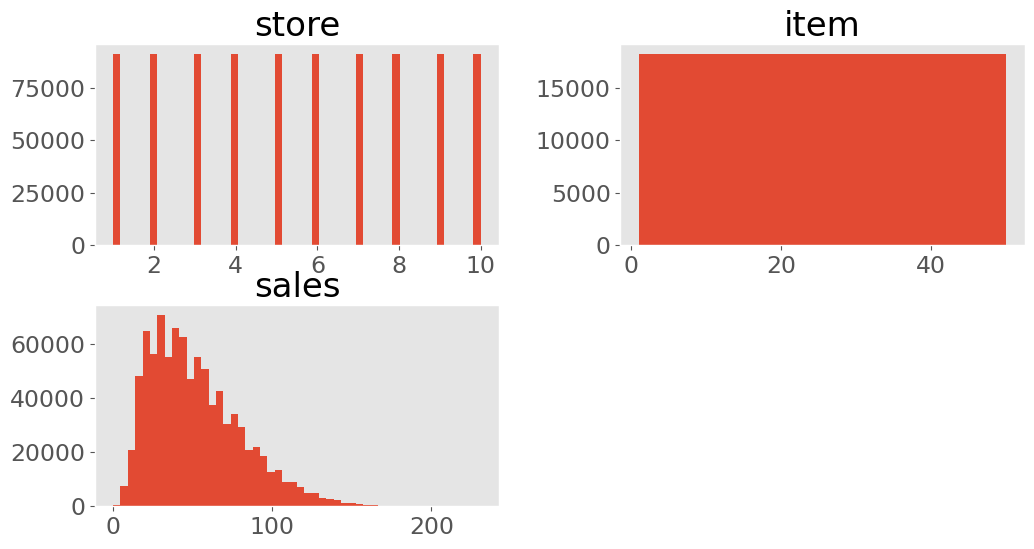

In [13]:
num_att.hist(figsize=(12, 6), bins=50, grid=False, histtype='stepfilled');

We have a minimum sales value of zero which is is strange.

In [14]:
df_desc.query('sales == 0')

,date,store,item,sales
64289,2014-01-15,6,4,0


## 1.6 Date

Checking if we have all the days between the first and the last day.

In [15]:
print(f'First date: {df_desc.date.min()}')
print(f'Last date: {df_desc.date.max()}')

First date: 2013-01-01 00:00:00
Last date: 2017-12-31 00:00:00


In [16]:
# days between = number of days - 1
(df_desc.date.max() - df_desc.date.min()).days == len(df_desc.date.unique()) - 1

True

# 2.0 Exploratory Data Analysis

In [17]:
def plot_most_sales_by(df: pd.DataFrame, variable: str, target: str, max_categories: int):

    assert isinstance(df, pd.DataFrame), 'df must be a DataFrame'
    assert isinstance(variable, str), 'variable must be a string'
    assert isinstance(target, str), 'target must be a string'
    assert isinstance(max_categories, int), 'max_categories must be a integer'

    plot_df = df.groupby(variable).sum(numeric_only=True)[[target]].sort_values(target, ascending=False).reset_index()

    bar = sns.barplot(data=plot_df, x=variable, y=target, order=plot_df[variable][:max_categories])

    plt.bar_label(bar.containers[0], fmt='%d');

In [18]:
df_eda = df_desc.copy()

1. What are the top 10 most sold products?
2. Which store has the most sales?
3. What is the sales trend by year, month, and day?

### 1. What are the top 10 most sold products?

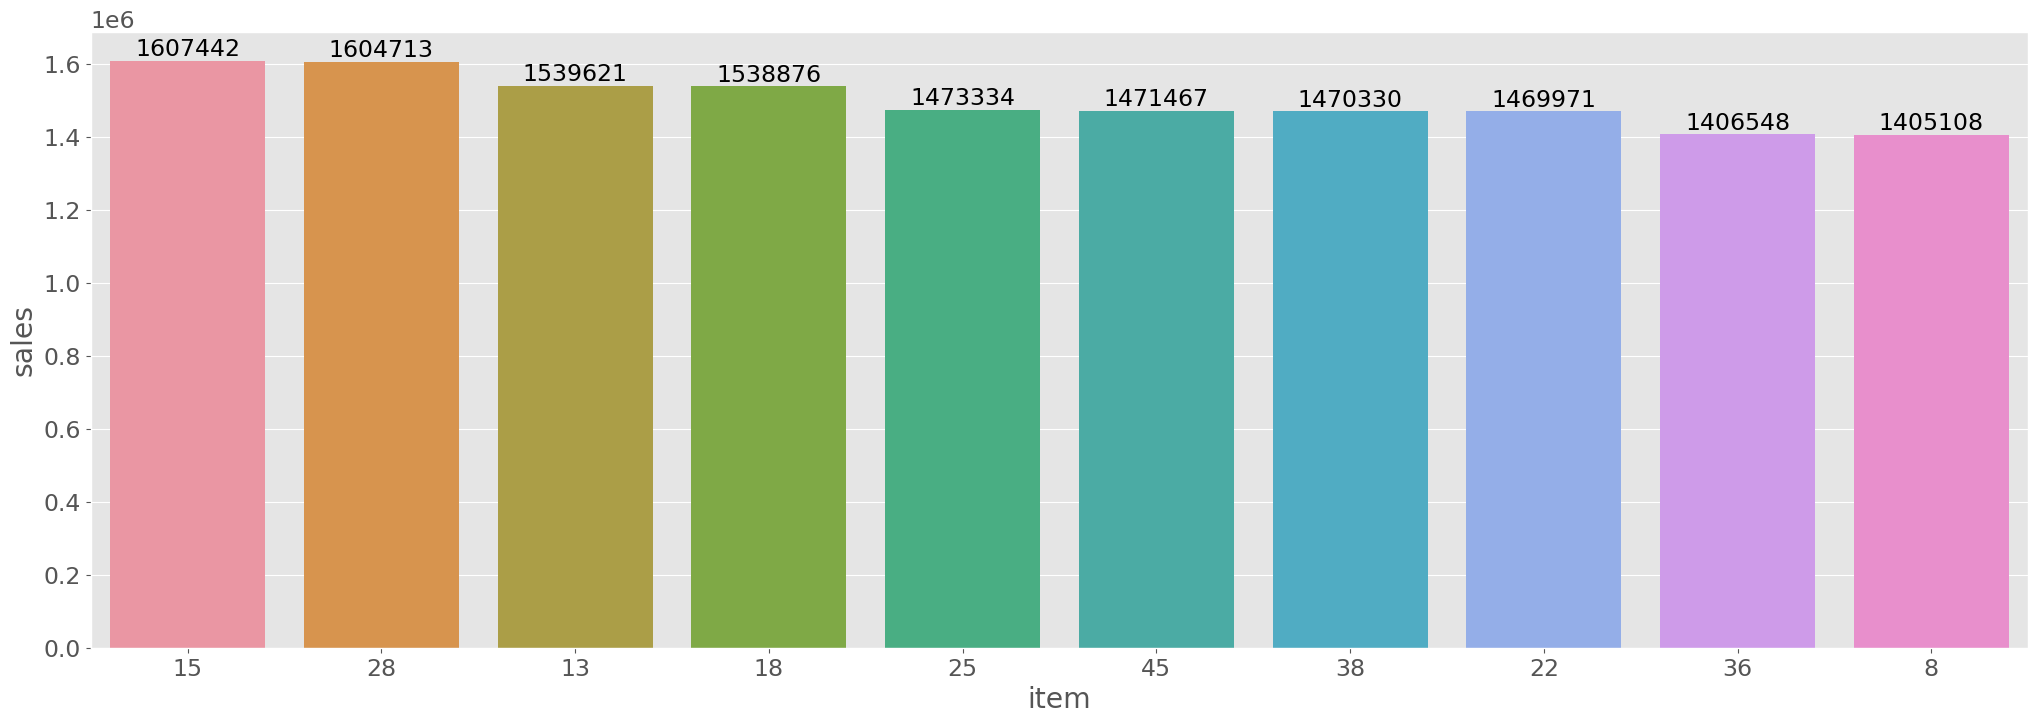

In [19]:
plot_most_sales_by(df=df_eda, variable='item', target='sales', max_categories=10)

### 2. Which stores has the most sales?

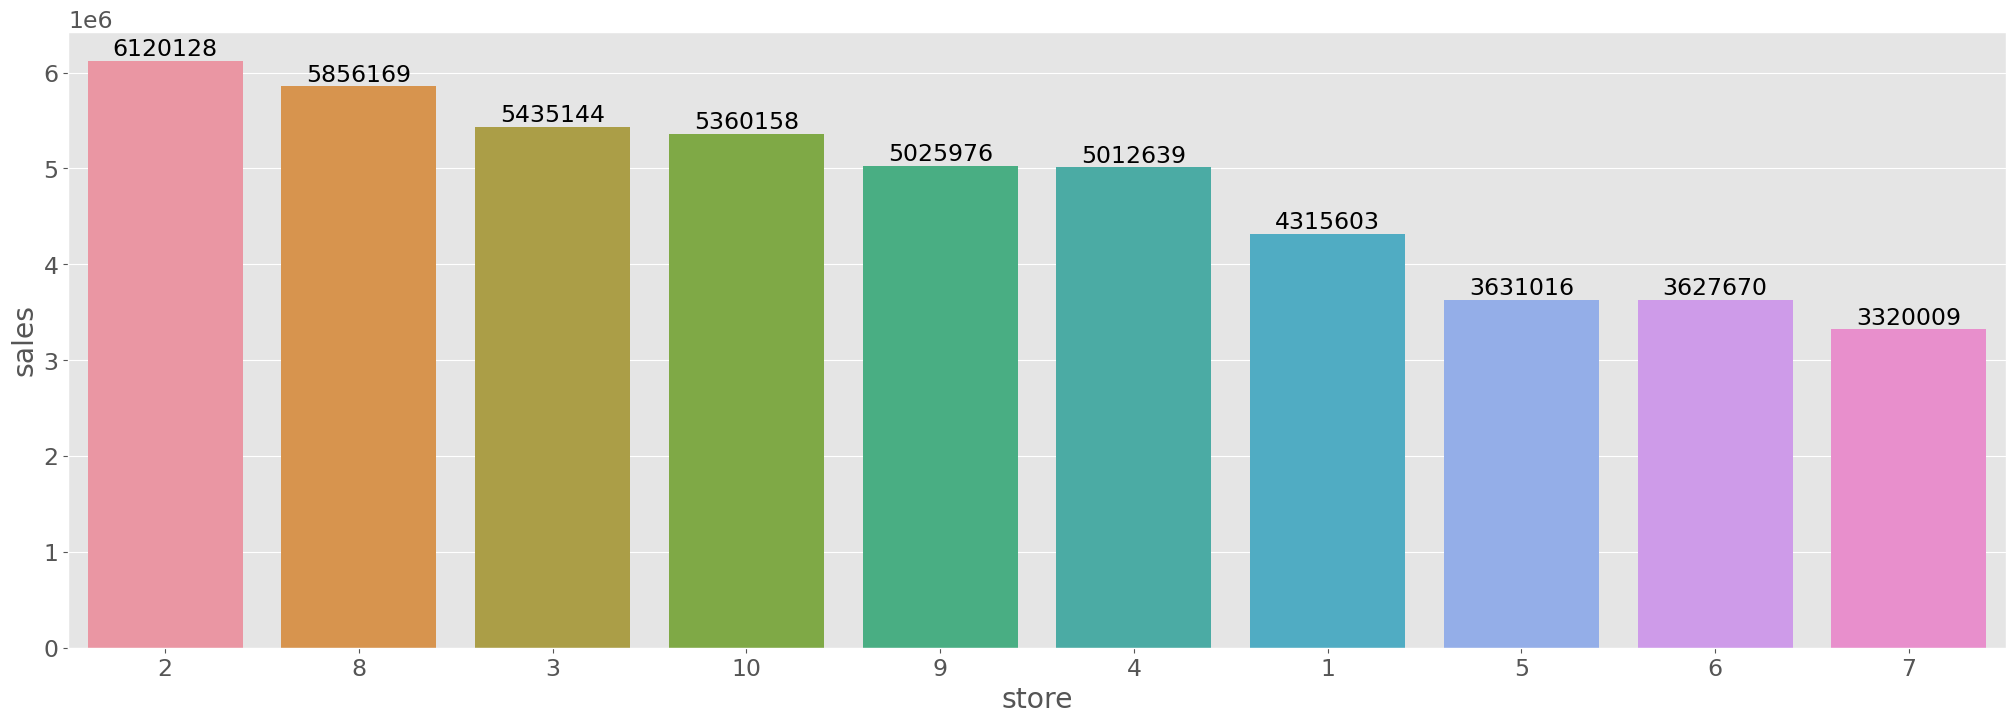

In [20]:
plot_most_sales_by(df=df_eda, variable='store', target='sales', max_categories=10)

### 3. What is the sales trend by year, month, and day?

In [21]:
df_series = df_eda.copy()[['date', 'sales']].set_index('date')

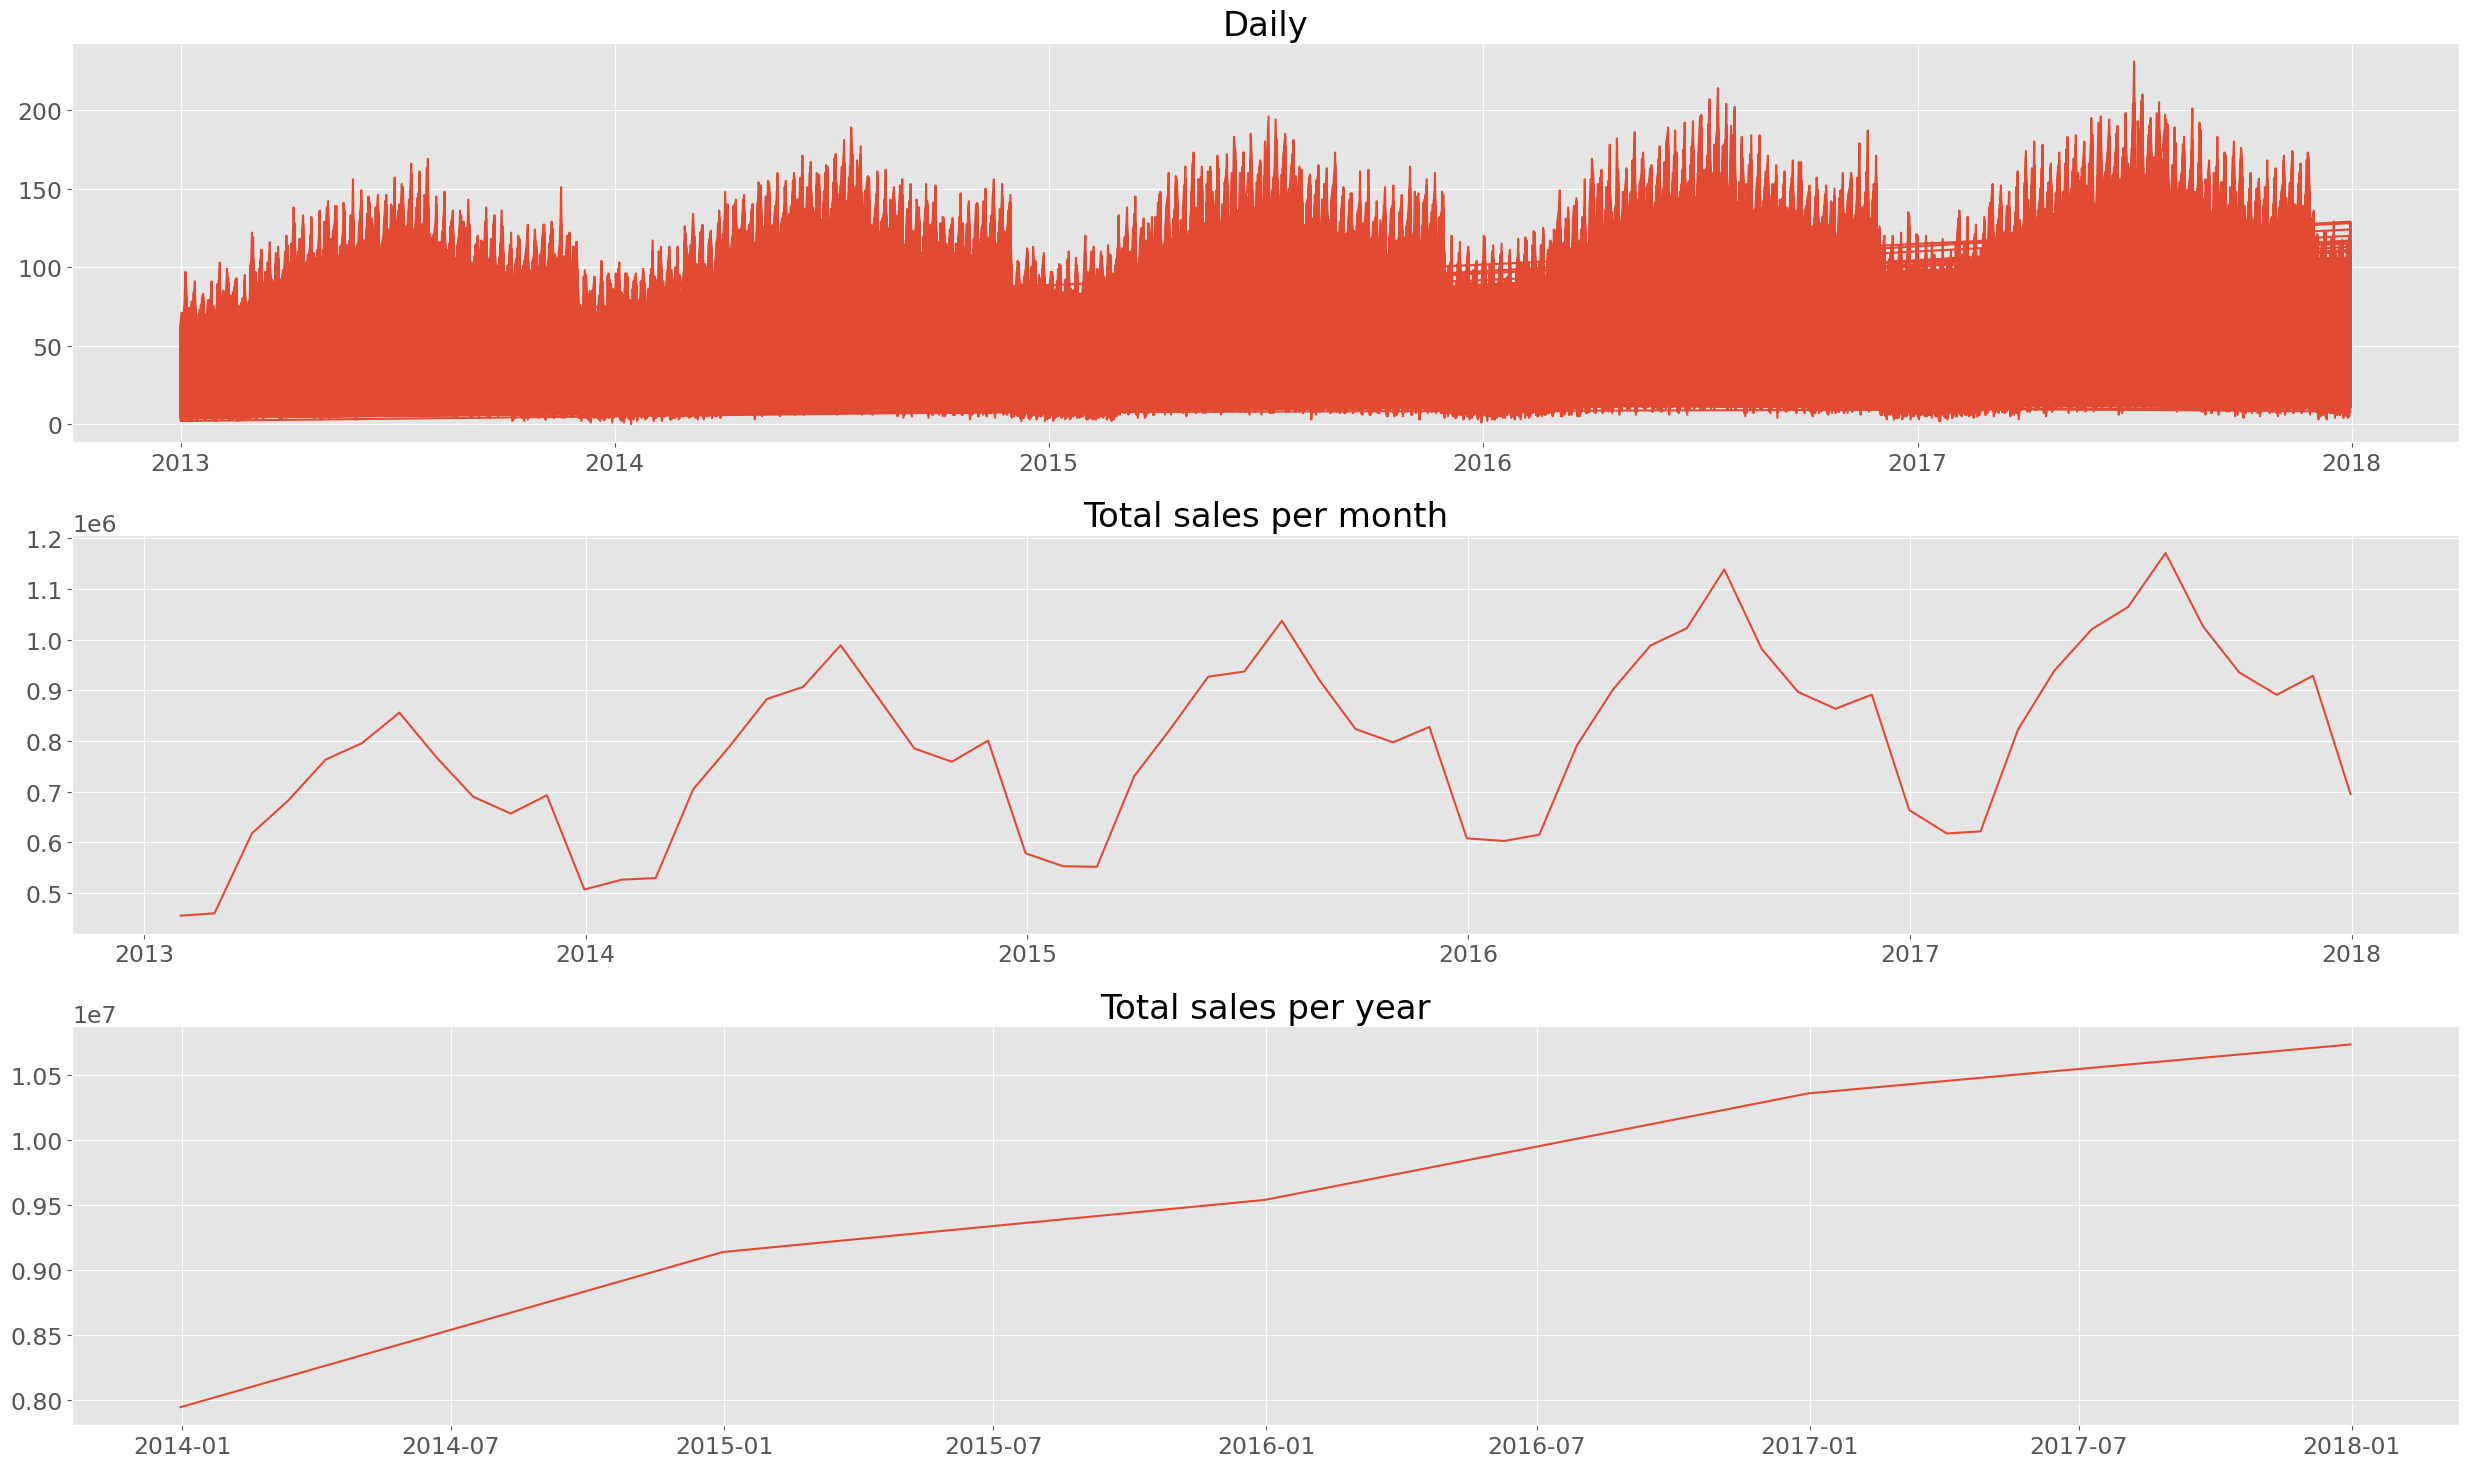

In [22]:
_, axis = plt.subplots(nrows=3, ncols=1, figsize=(25, 15))

axis[0].plot(df_series)
axis[0].set_title('Daily')

axis[1].plot(df_series.resample('m').sum())
axis[1].set_title('Total sales per month')

axis[2].plot(df_series.resample('a').sum())
axis[2].set_title('Total sales per year')
plt.tight_layout()

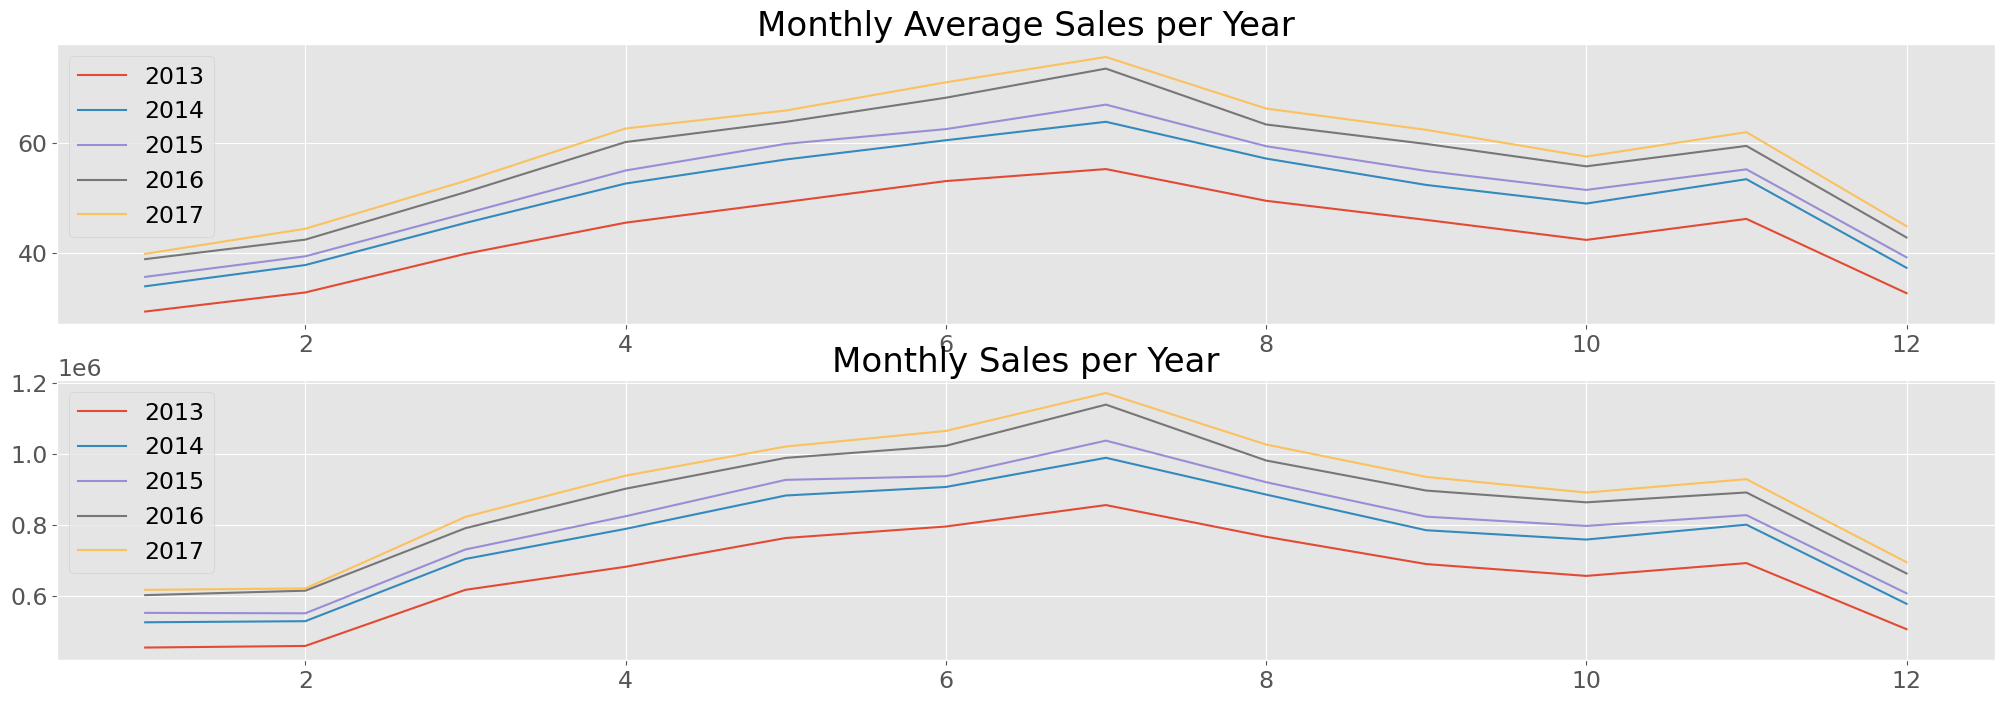

In [23]:
year_plot = df_series.copy()
year_plot['year'] = year_plot.index.year
year_plot['month'] = year_plot.index.month

year_plot = year_plot.groupby(['year', 'month']).agg(['mean', 'sum']).reset_index()
cols = year_plot.columns.to_list()

plt.subplot(2, 1, 1)
for year_ in year_plot.year.unique():

    plt.plot(year_plot.loc[year_plot['year'] == year_]['month'], year_plot.loc[year_plot['year'] == year_][cols[2]], label=year_)
plt.legend()
plt.title('Monthly Average Sales per Year')

plt.subplot(2, 1, 2)
for year_ in year_plot.year.unique():
    
    plt.plot(year_plot.loc[year_plot['year'] == year_]['month'], year_plot.loc[year_plot['year'] == year_][cols[3]], label=year_)
plt.legend()
plt.title('Monthly Sales per Year');

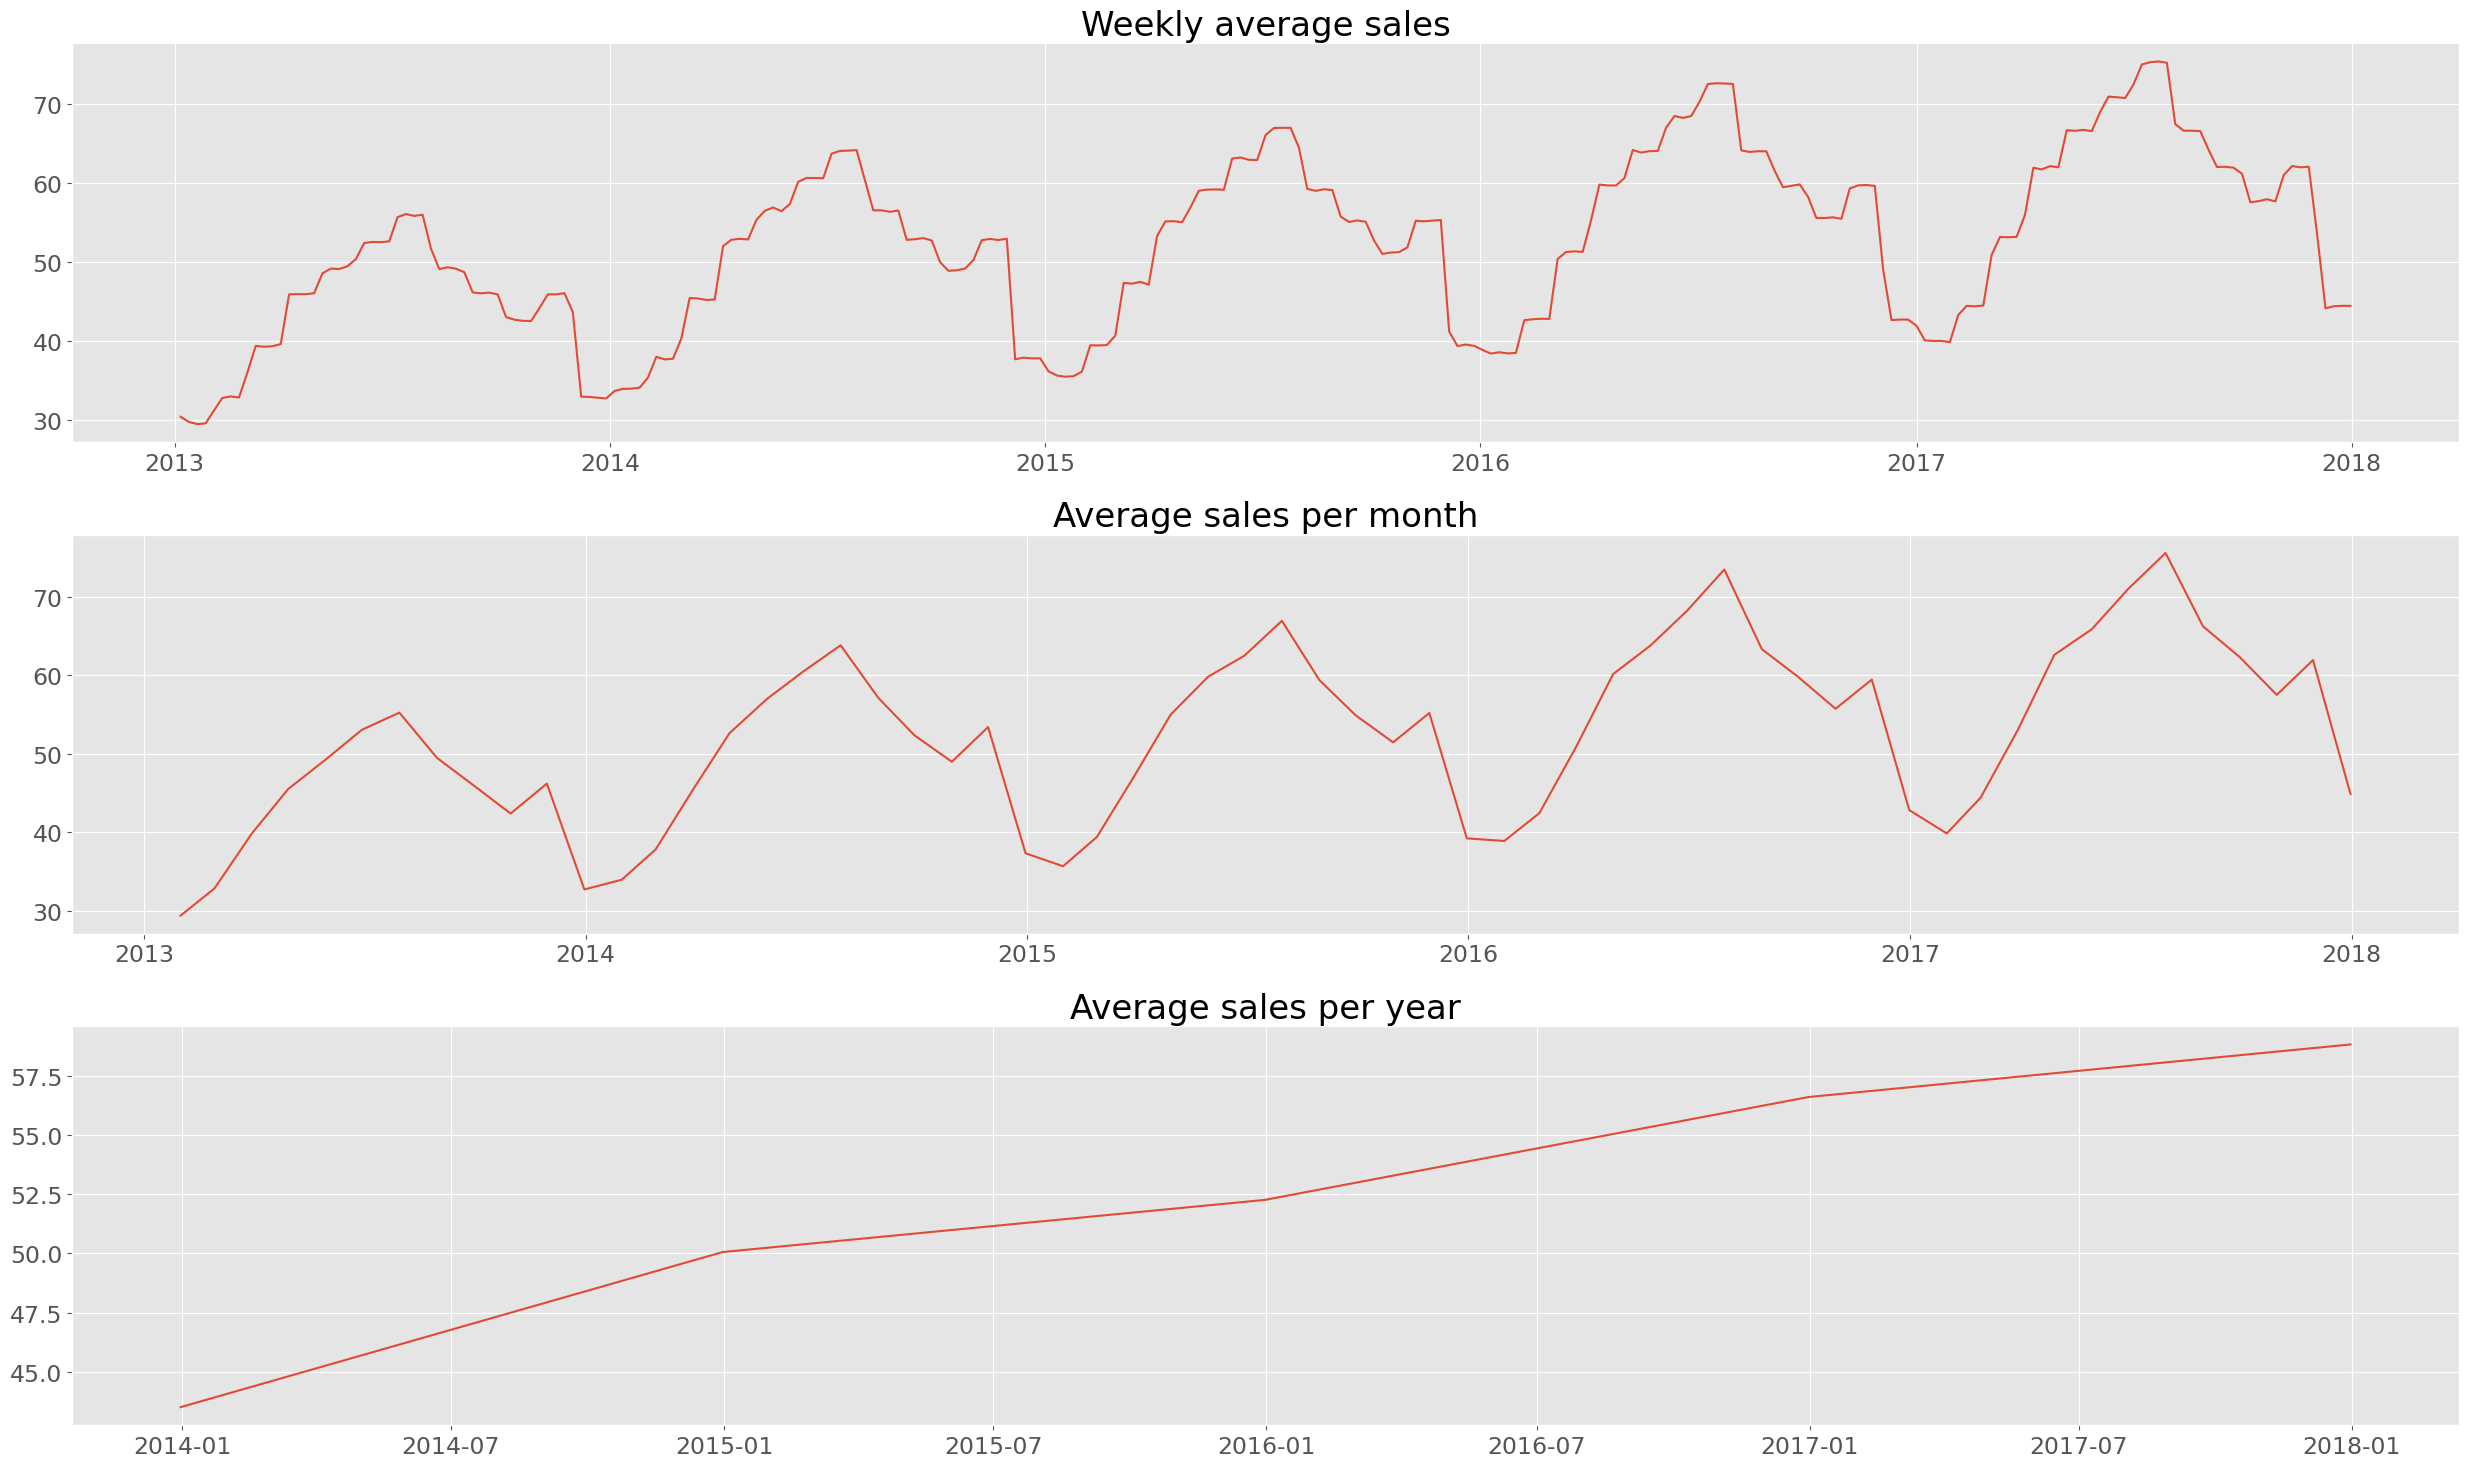

In [24]:
_, axis = plt.subplots(nrows=3, ncols=1, figsize=(25, 15))

axis[0].plot(df_series.resample('w').mean())
axis[0].set_title('Weekly average sales')

axis[1].plot(df_series.resample('m').mean())
axis[1].set_title('Average sales per month')

axis[2].plot(df_series.resample('a').mean())
axis[2].set_title('Average sales per year')
plt.tight_layout()

<AxesSubplot:xlabel='date'>

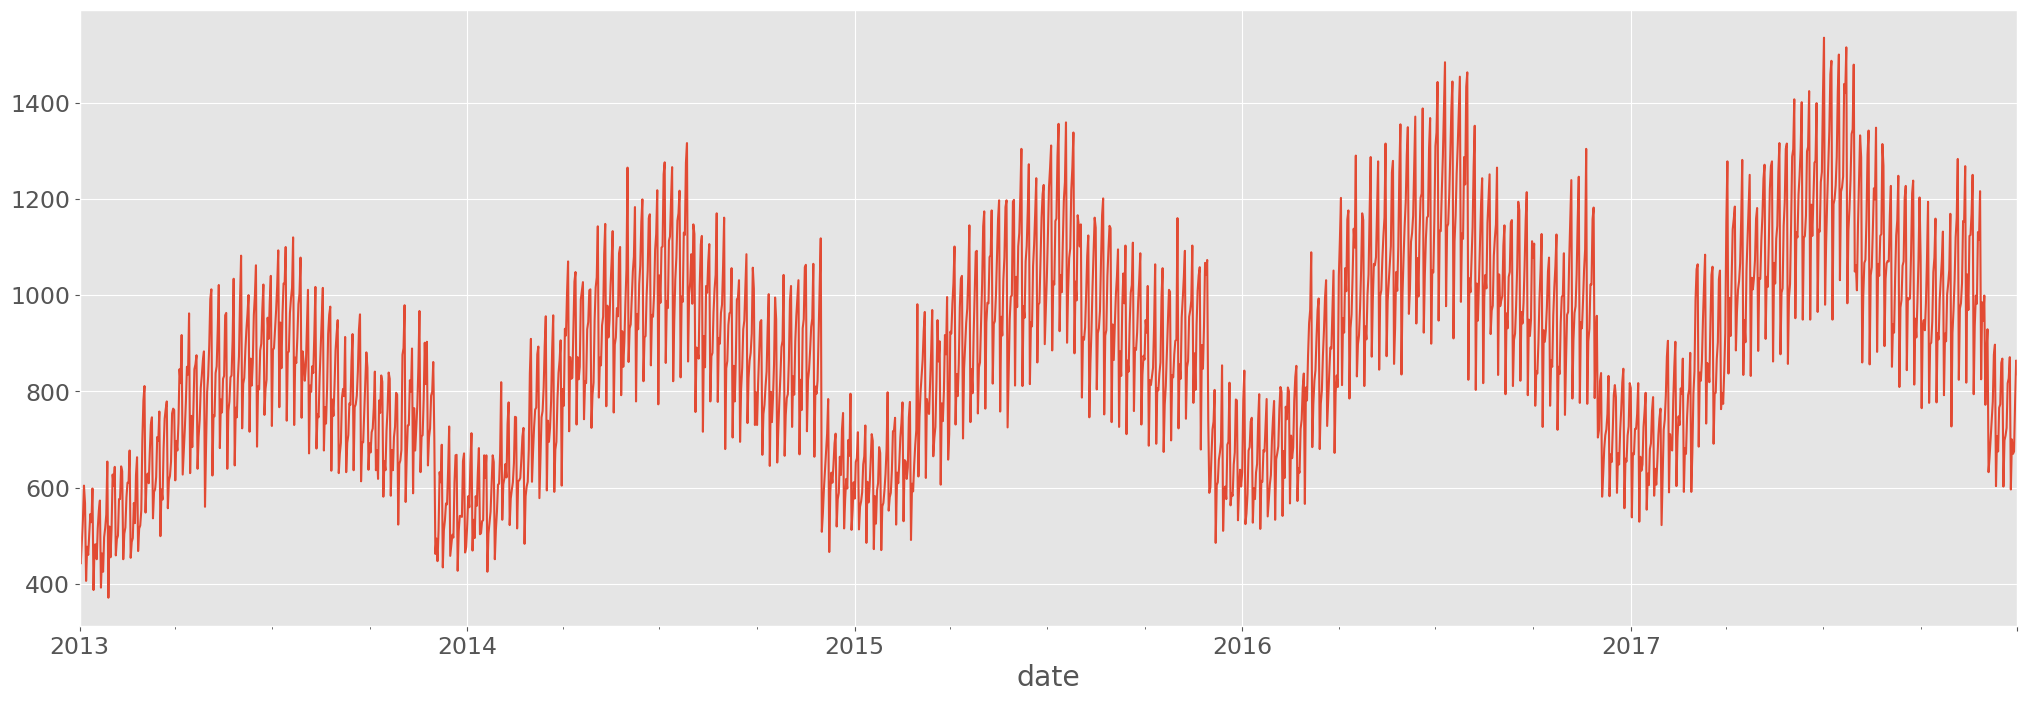

In [25]:
df_eda.query('item == 15').groupby('date').sum()['sales'].plot()

## 3.0 Product Segmentation

Only the data of the past two years will be used.

In [26]:
sales_df = df_eda.copy()[df_eda.date.dt.year >= 2016]

In [27]:
sales_by_prod = sales_df.groupby('item').sum(numeric_only=True).sort_values('sales', ascending=False).reset_index().drop(columns='store')

We will only work with the high-revenue SKUs.

We will use ABC segmentation, it goes as follows:

- Class A -> The products driving most revenue (products that generate 70% of the revenue).
- Class B -> The products in the middle (products that generate 25% of the revenue).
- Class C -> The products driving very little revenue (generate less than 5% of the revenue).

In [28]:
# Accumulated sales per produc
sales_by_prod['acc_sales'] = sales_by_prod.sales.cumsum()

sales_by_prod['sales_perc'] = sales_by_prod['acc_sales']/sales_by_prod.sales.sum()

sales_by_prod['product_%'] = np.array([i + 1 for i in range(len(sales_by_prod))])/len(sales_by_prod)

In [29]:
class_a_index = sales_by_prod.query('(sales_perc >= 0.695) & (sales_perc <= 0.71)').index[0]+1
class_b_index = sales_by_prod.query('(sales_perc >= 0.95) & (sales_perc <= 0.96)').head(1).index[0]+1


class_a_items = sales_by_prod[:class_a_index].item

In [30]:
class_a_items.unique()

array([15, 28, 13, 18, 25, 45, 38, 22,  8, 36, 10, 11, 29, 12, 33, 24, 50,
       35, 14, 46, 31,  2,  6,  7, 48, 43], dtype=uint64)

# 4.0 Demand Distribution

## 4.1 Item 15

In [31]:
product = class_a_items[0]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')
#daily_sales

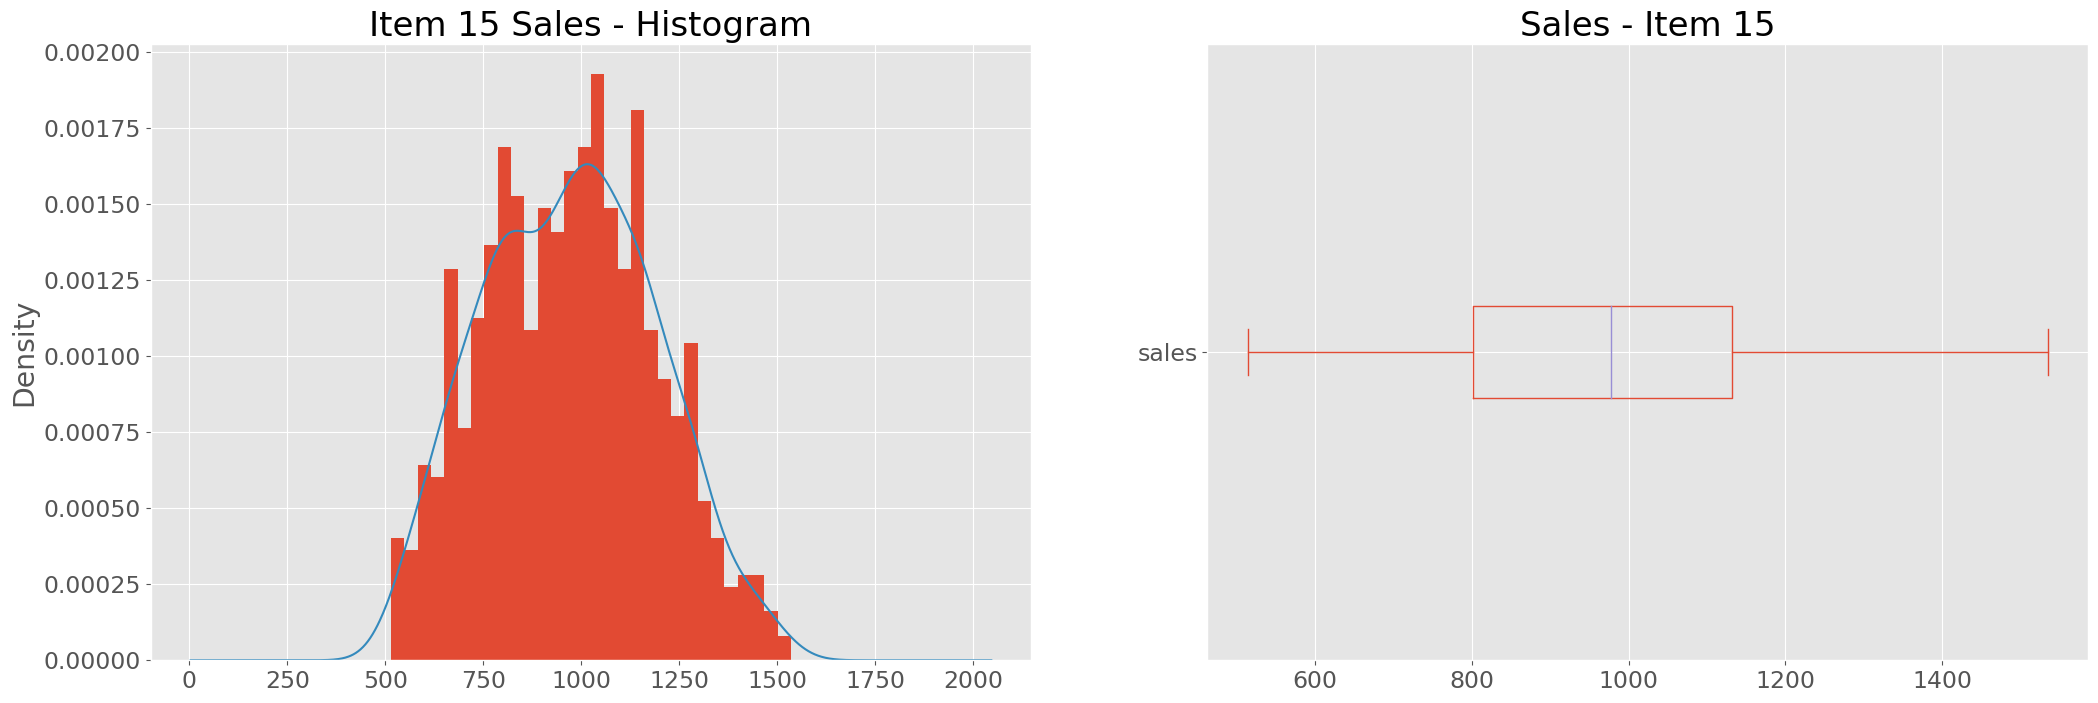

In [32]:
plt.title(f'Sales - Item {product}')
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)
plt.title(f'Sales - Item {product}');

We notice that the daily sales distribution is similar to a normal distribution with a few outliers. But we can't say it is normal distributed.

In [33]:
test_normality(daily_sales.sales)

p-value: 0.0000
Reject the null Hypothesis. We can't say it is normal distributed


### Applying the Central Limit Theorem

-> Take multiple samples with 30 or more days per samples.

-> Find the mean of each sample.

-> The sample means will be normally distributed.

In [34]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

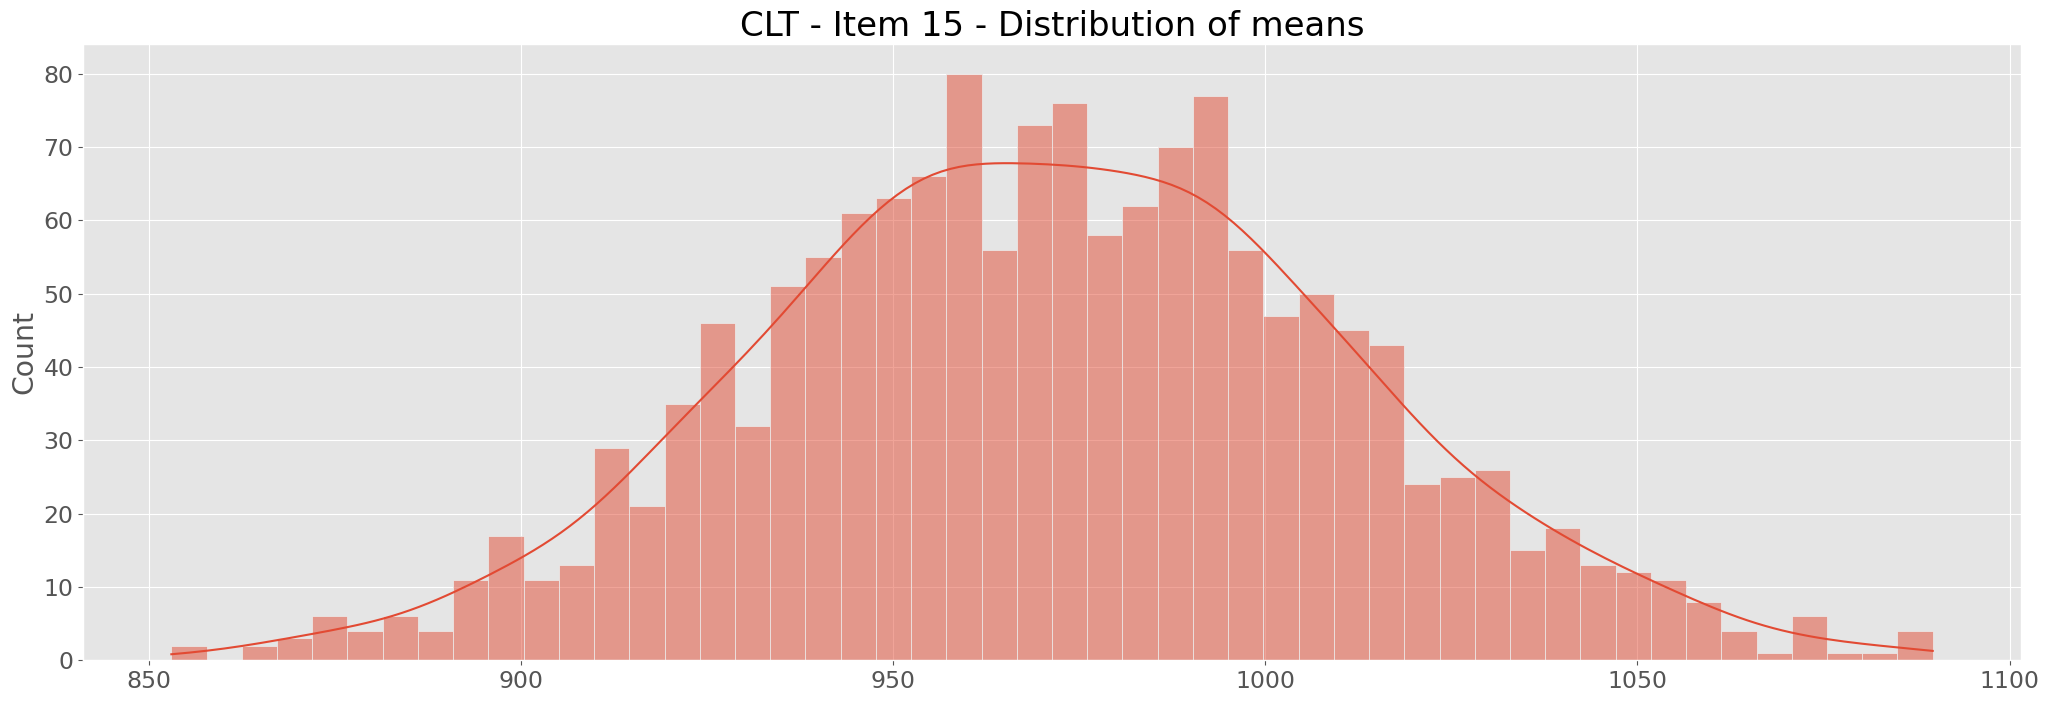

In [35]:
hist_means(samples_means, product=product)

In [36]:
test_normality(samples_means)

p-value: 0.6188
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [37]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 971.7455540355677
Sample mean: 971.909
Population standard deviation: 39.698983040843714
Sample standard deviation: 39.36780792070447


**Now, we can answer some questions about the product.**

I sell 1020 units of this product a day.

H0 I sell 1020 units of this product a day

- sales = 1020

H1: I do not sell 1020 units of this product a day.

- sales != 1020

### 1. What is the probability that I will sell 1050 units a day?

In [38]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [39]:
target_ = 1050
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 1050 units or more is 2.36%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [40]:
target_ = 1000
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 1000 units every day is 23.78%


### 3. What is the range which contains 90% of my possible demand?

In [41]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [907    ———    1037]


### 4. How much stock should I have if I want 20% probability of stocking out?

In [42]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 1005 units in your stock if you want a 20.0% probability of stocking out.


### 5. After running a promotion, has the discount improved daily sales?

With the data we have, it is not possible to answer this question.

## 4.2 Item 28

In [43]:
product = class_a_items[1]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')
# sales_28

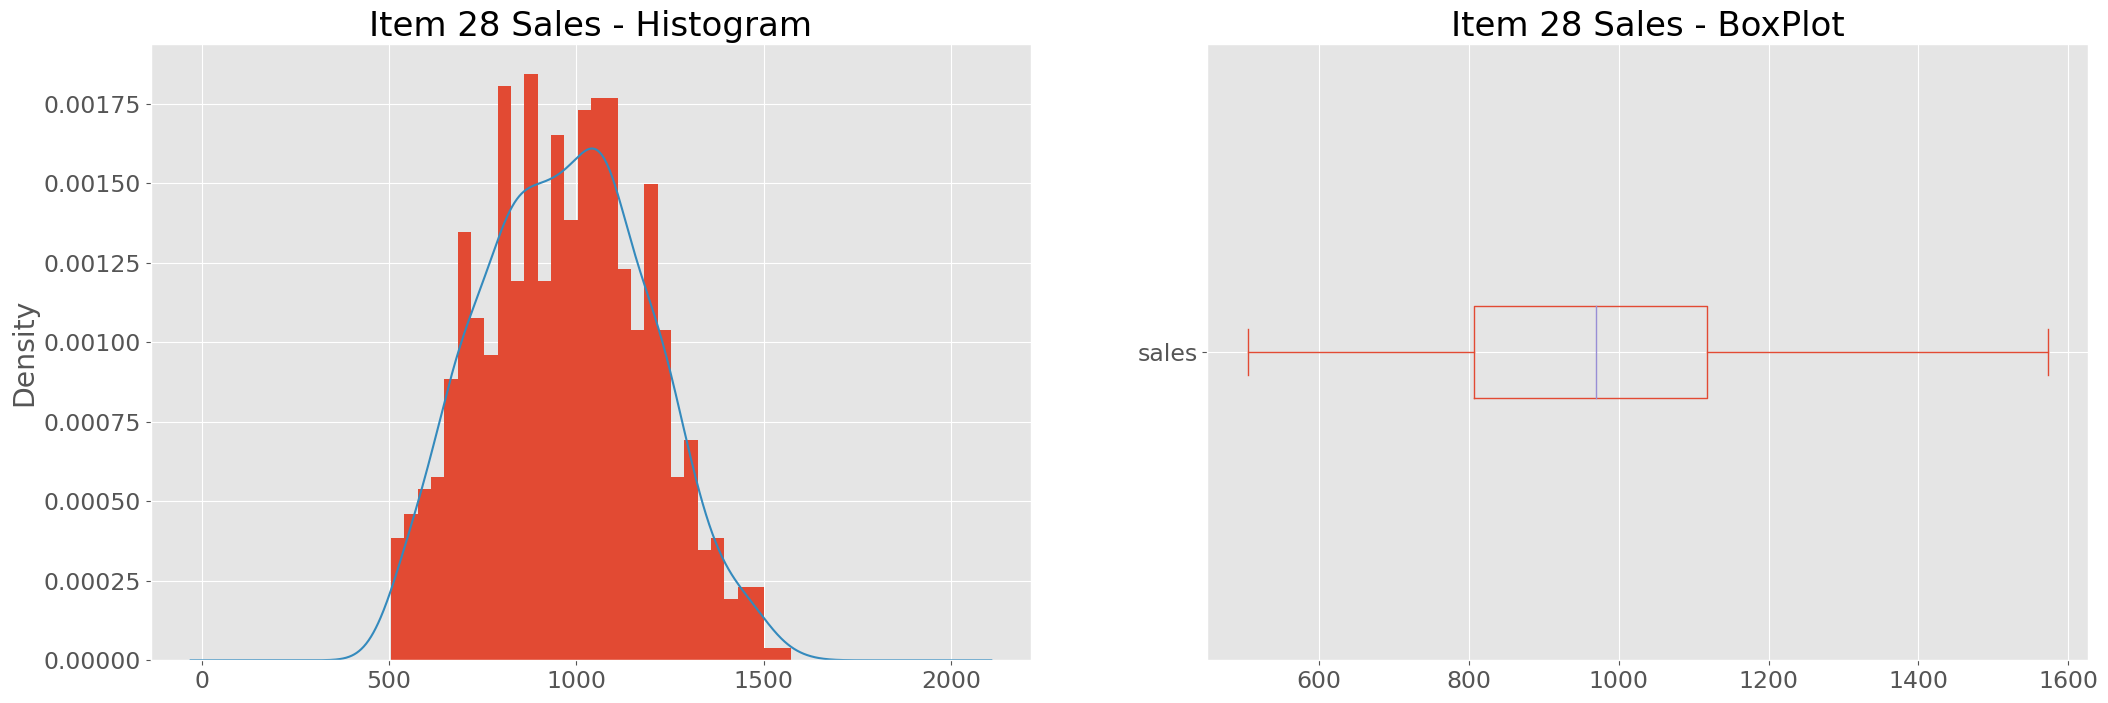

In [44]:
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)

In [45]:
test_normality(daily_sales.sales)

p-value: 0.0000
Reject the null Hypothesis. We can't say it is normal distributed


### CLT

In [46]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

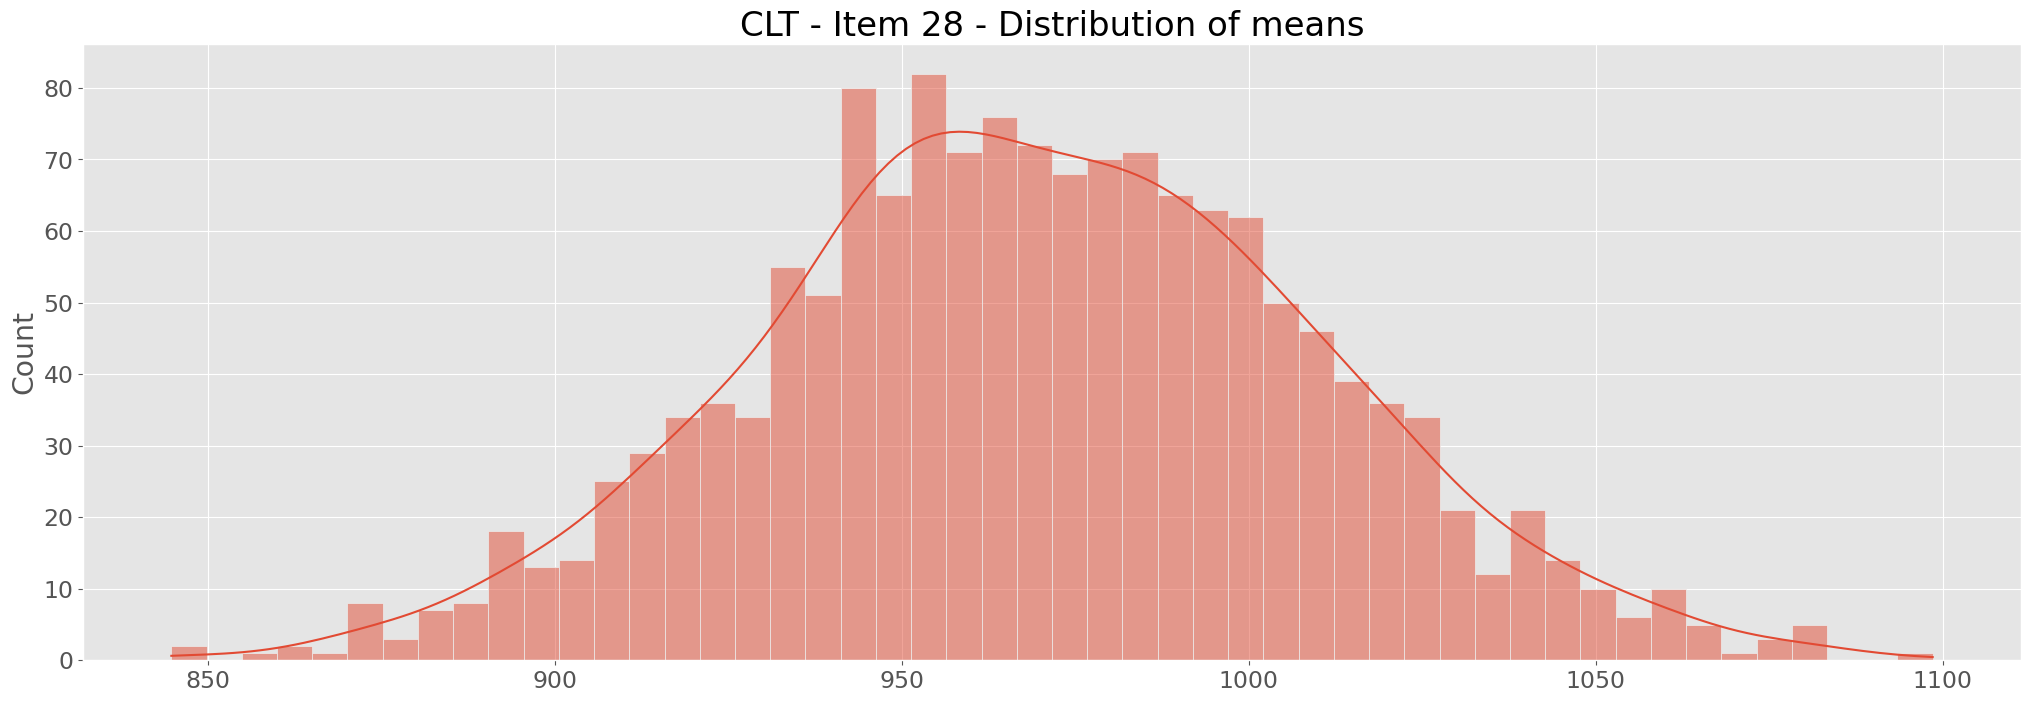

In [47]:
hist_means(samples_means, product=product);

In [48]:
test_normality(samples_means)

p-value: 0.6923
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [49]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 969.8057455540355
Sample mean: 969.9603777777778
Population standard deviation: 39.94093722583412
Sample standard deviation: 39.851638784160556


### 1. What is the probability that I will sell 1050 units a day?

In [50]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [51]:
target_ = 1050
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 1050 units or more is 2.23%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [52]:
target_ = 1000
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 1000 units every day is 22.55%


### 3. What is the range which contains 90% of my possible demand?

In [53]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [904    ———    1036]


### 4. How much stock should I have if I want 20% probability of stocking out?

In [54]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 1004 units in your stock if you want a 20.0% probability of stocking out.


## 4.3 Item 13

In [163]:
product = class_a_items[2]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')
# sales_28

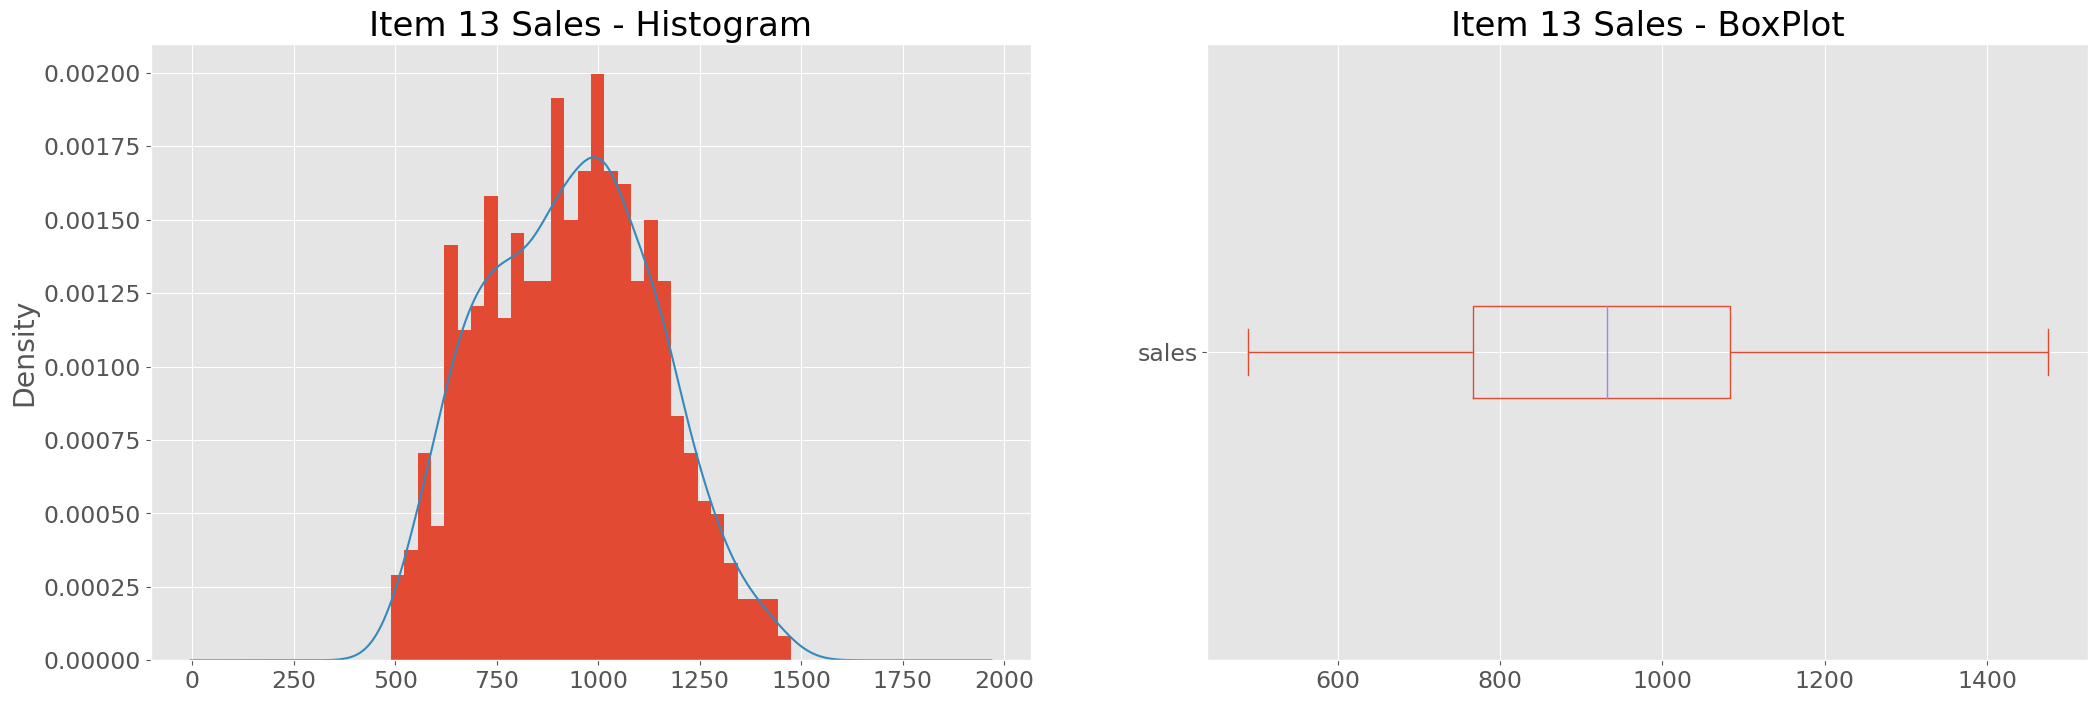

In [164]:
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)

In [165]:
test_normality(daily_sales.sales)

p-value: 0.0000
Reject the null Hypothesis. We can't say it is normal distributed


### CLT

In [166]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

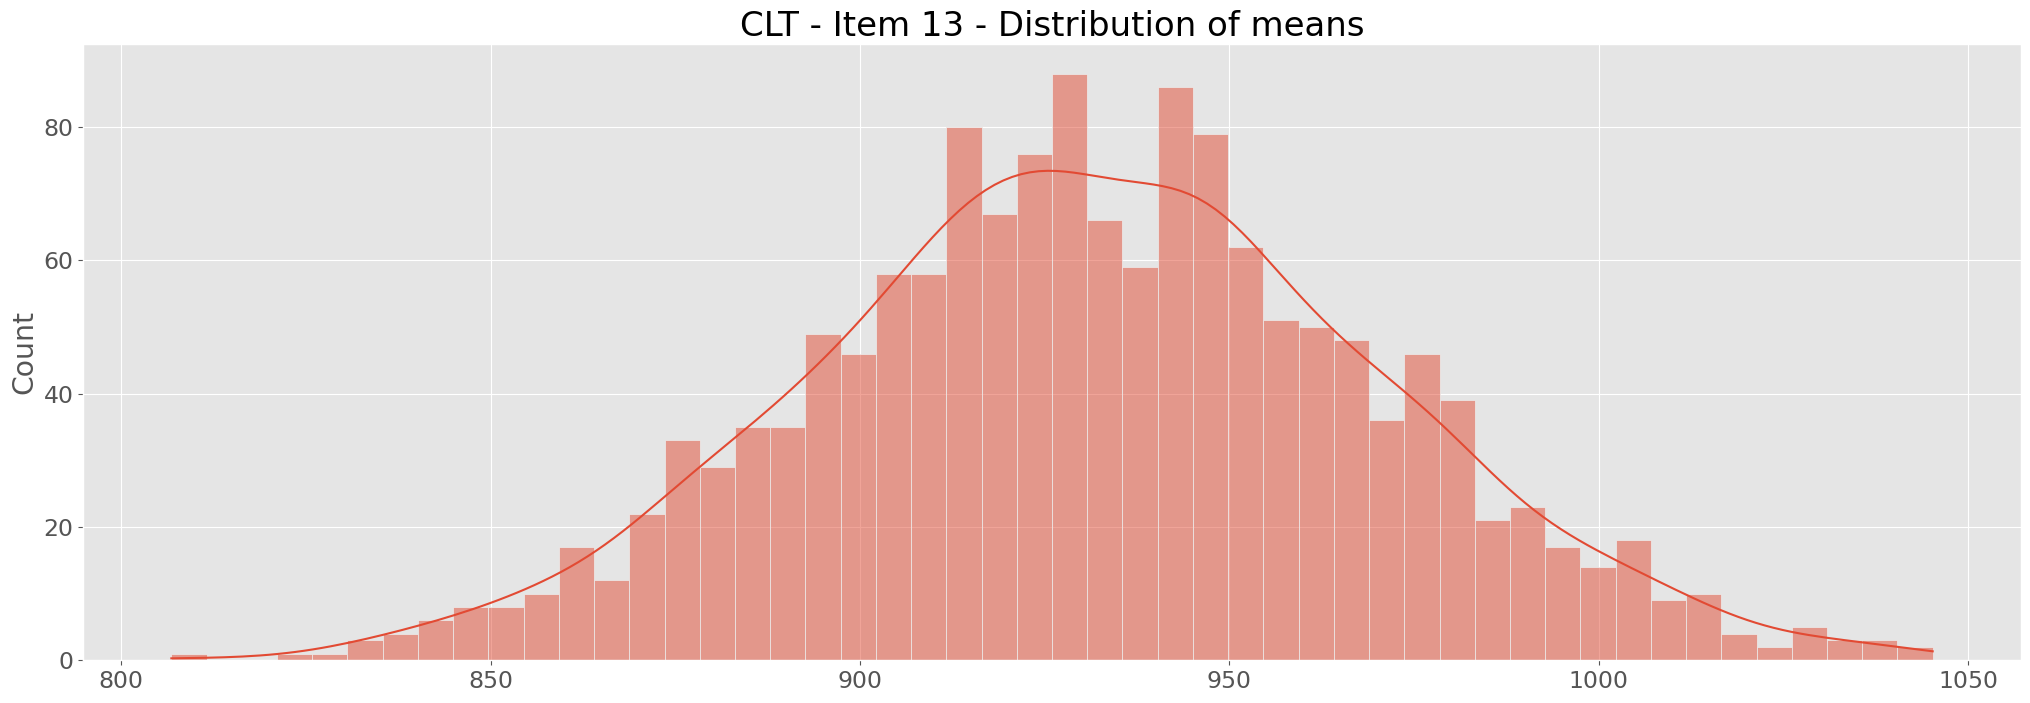

In [167]:
hist_means(samples_means, product=product);

In [168]:
test_normality(samples_means)

p-value: 0.7213
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [169]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 931.593707250342
Sample mean: 931.8849333333333
Population standard deviation: 37.98074514037292
Sample standard deviation: 38.087172425449566


### 1. What is the probability that I will sell 1000 units a day?

In [170]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [171]:
target_ = 1000
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 1000 units or more is 3.69%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [173]:
target_ = 950
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 950 units every day is 31.72%


### 3. What is the range which contains 90% of my possible demand?

In [174]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [869    ———    995]


### 4. How much stock should I have if I want 80% probability of stocking out?

In [175]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 964 units in your stock if you want a 20.0% probability of stocking out.


## 4.4 Item 18

In [176]:
product = class_a_items[3]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')

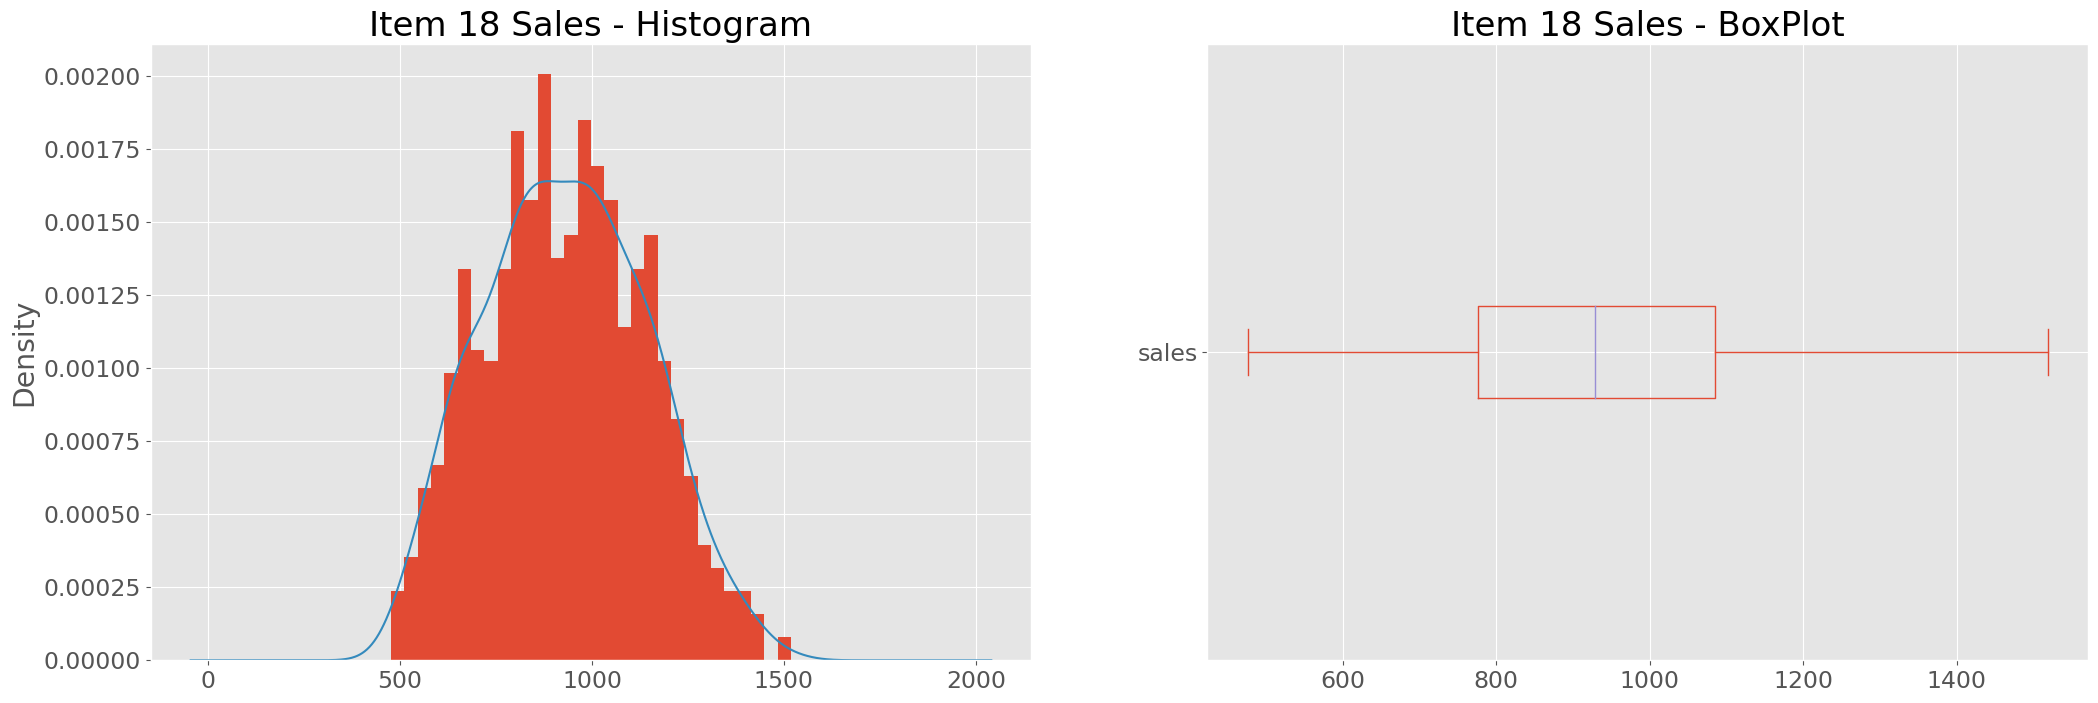

In [177]:
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)

In [178]:
test_normality(daily_sales.sales)

p-value: 0.0000
Reject the null Hypothesis. We can't say it is normal distributed


### CLT

In [179]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

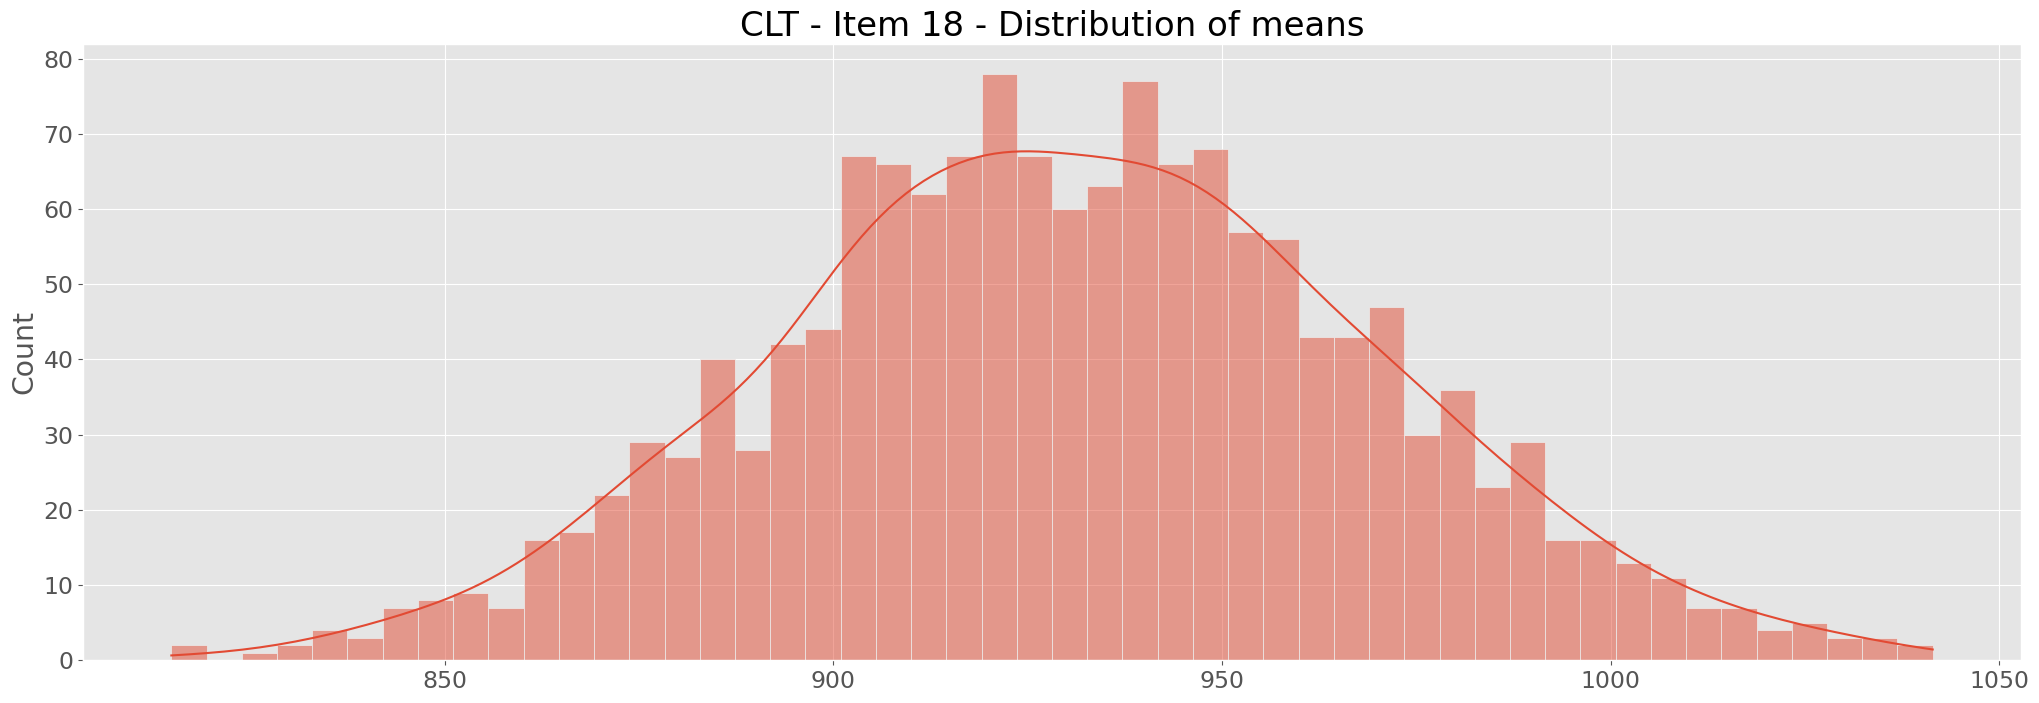

In [180]:
hist_means(samples_means, product=product);

In [181]:
test_normality(samples_means)

p-value: 0.3560
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [182]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 931.0383036935705
Sample mean: 931.2804444444444
Population standard deviation: 38.31759549532333
Sample standard deviation: 38.164559978086835


### 1. What is the probability that I will sell 1050 units a day?

In [183]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [184]:
target_ = 1050
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 1050 units or more is 0.09%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [185]:
target_ = 1000
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 1000 units every day is 3.59%


### 3. What is the range which contains 90% of my possible demand?

In [186]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [869    ———    994]


### 4. How much stock should I have if I want 80% probability of stocking out?

In [187]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 963 units in your stock if you want a 20.0% probability of stocking out.


## 4.5 Item 25

In [188]:
product = class_a_items[4]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')

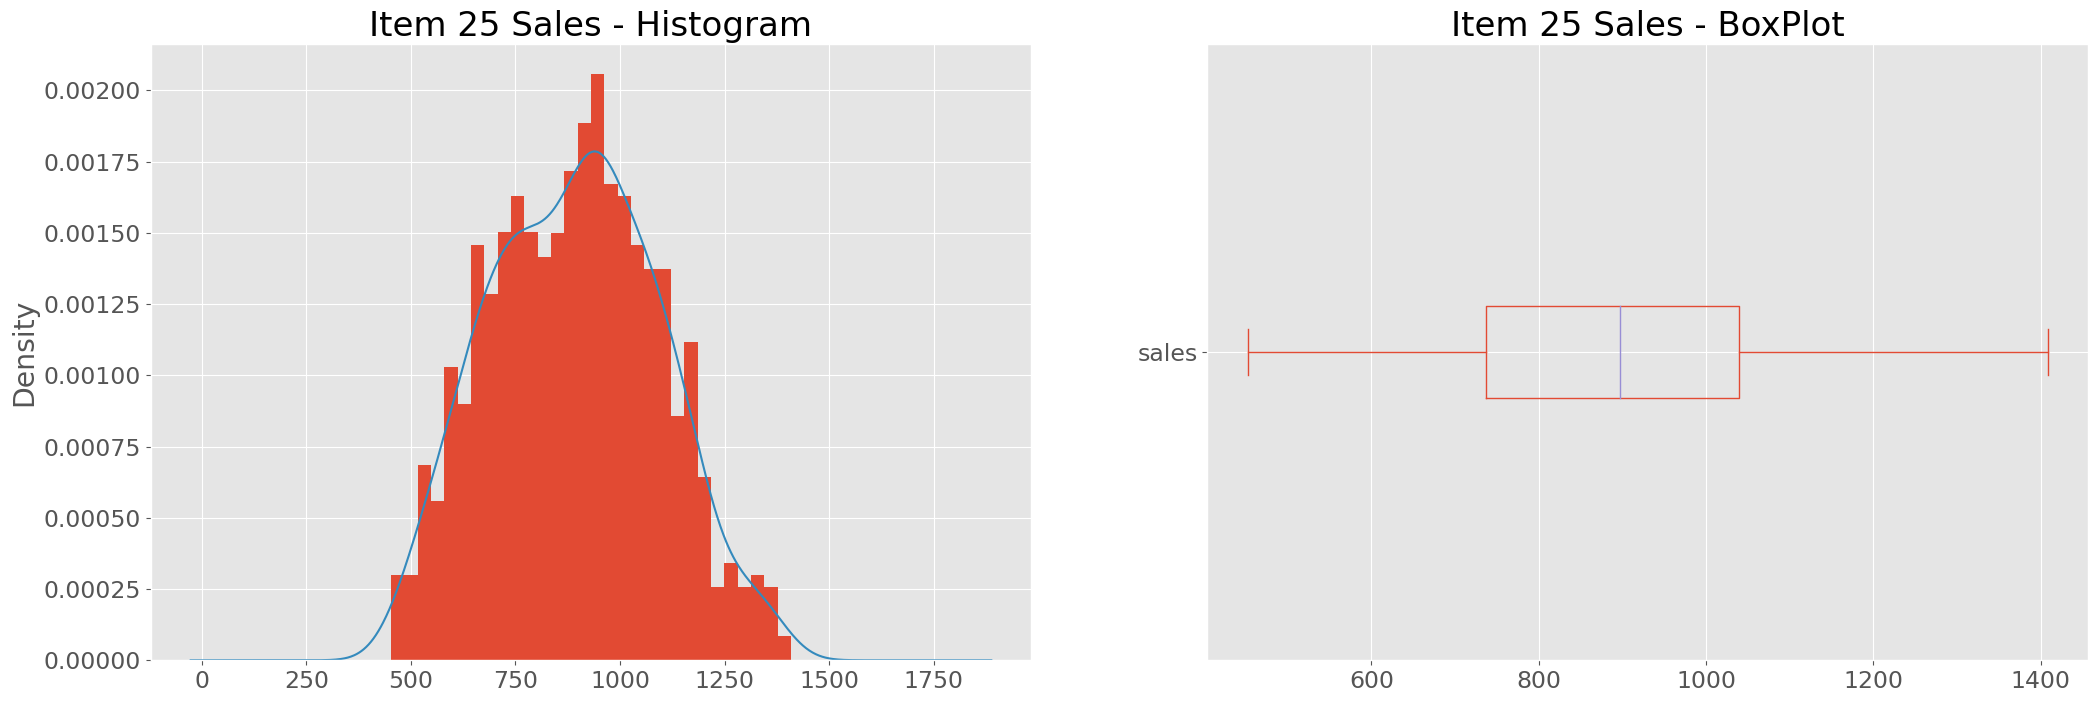

In [189]:
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)

In [190]:
test_normality(daily_sales.sales)

p-value: 0.0000
Reject the null Hypothesis. We can't say it is normal distributed


### CLT

In [191]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

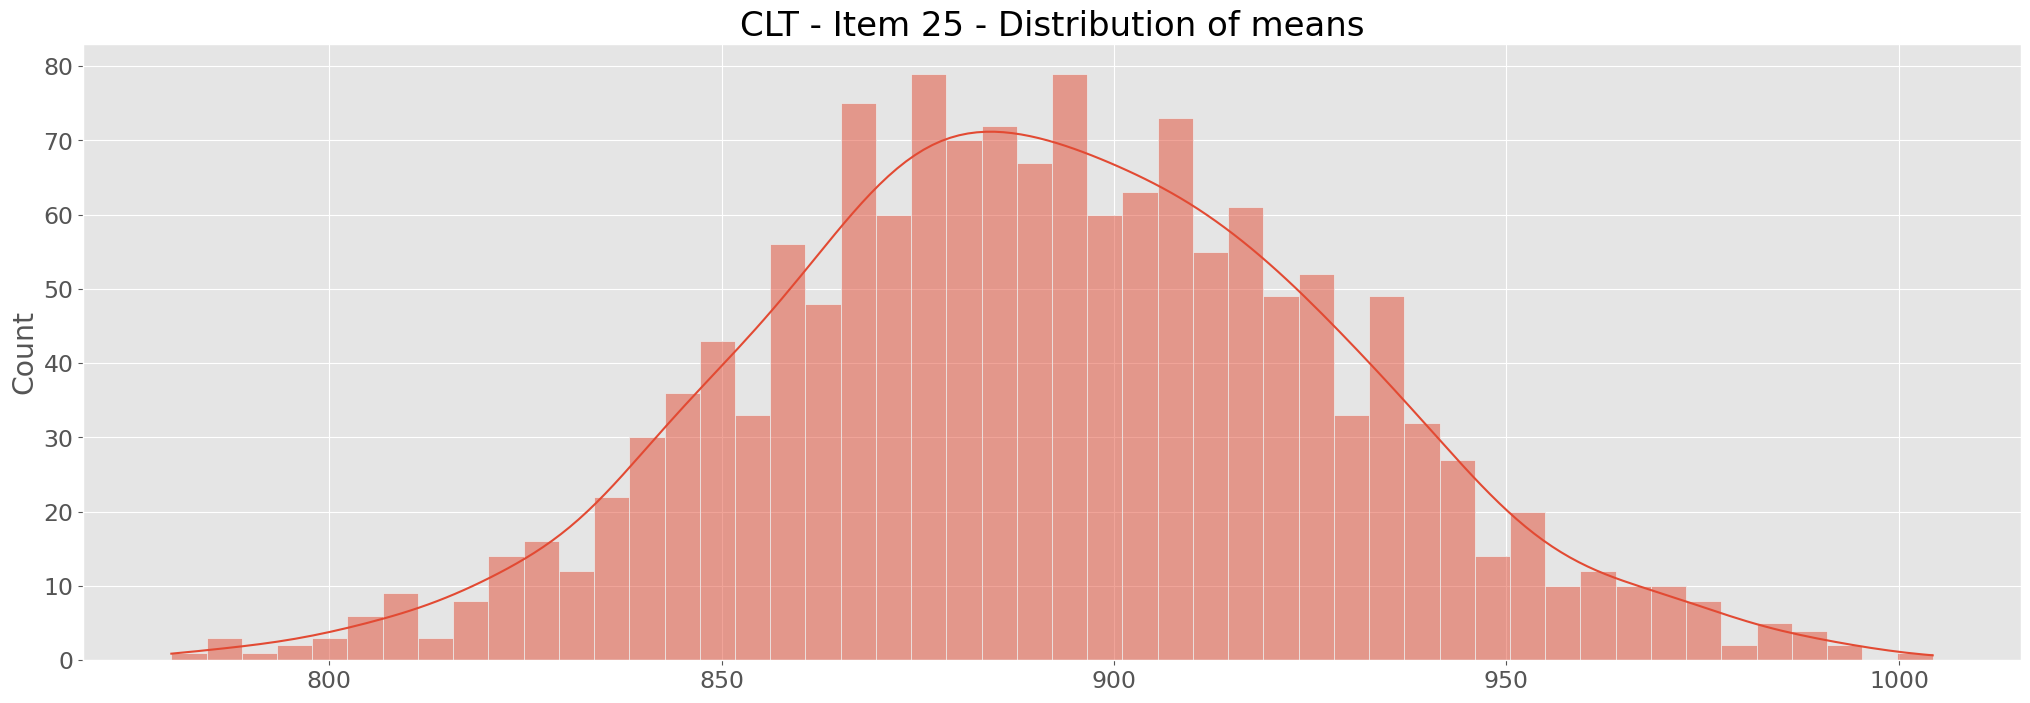

In [192]:
hist_means(samples_means, product=product);

In [193]:
test_normality(samples_means)

p-value: 0.6535
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [194]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 891.452804377565
Sample mean: 891.5090666666667
Population standard deviation: 36.71811363037467
Sample standard deviation: 36.483488472580156


### 1. What is the probability that I will sell 950 units a day?

In [196]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [198]:
target_ = 950
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 950 units or more is 5.44%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [199]:
target_ = 1000
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 1000 units every day is 0.15%


### 3. What is the range which contains 90% of my possible demand?

In [200]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [831    ———    952]


### 4. How much stock should I have if I want 80% probability of stocking out?

In [201]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 922 units in your stock if you want a 20.0% probability of stocking out.


## 4.6 Item 45

In [202]:
product = class_a_items[5]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')

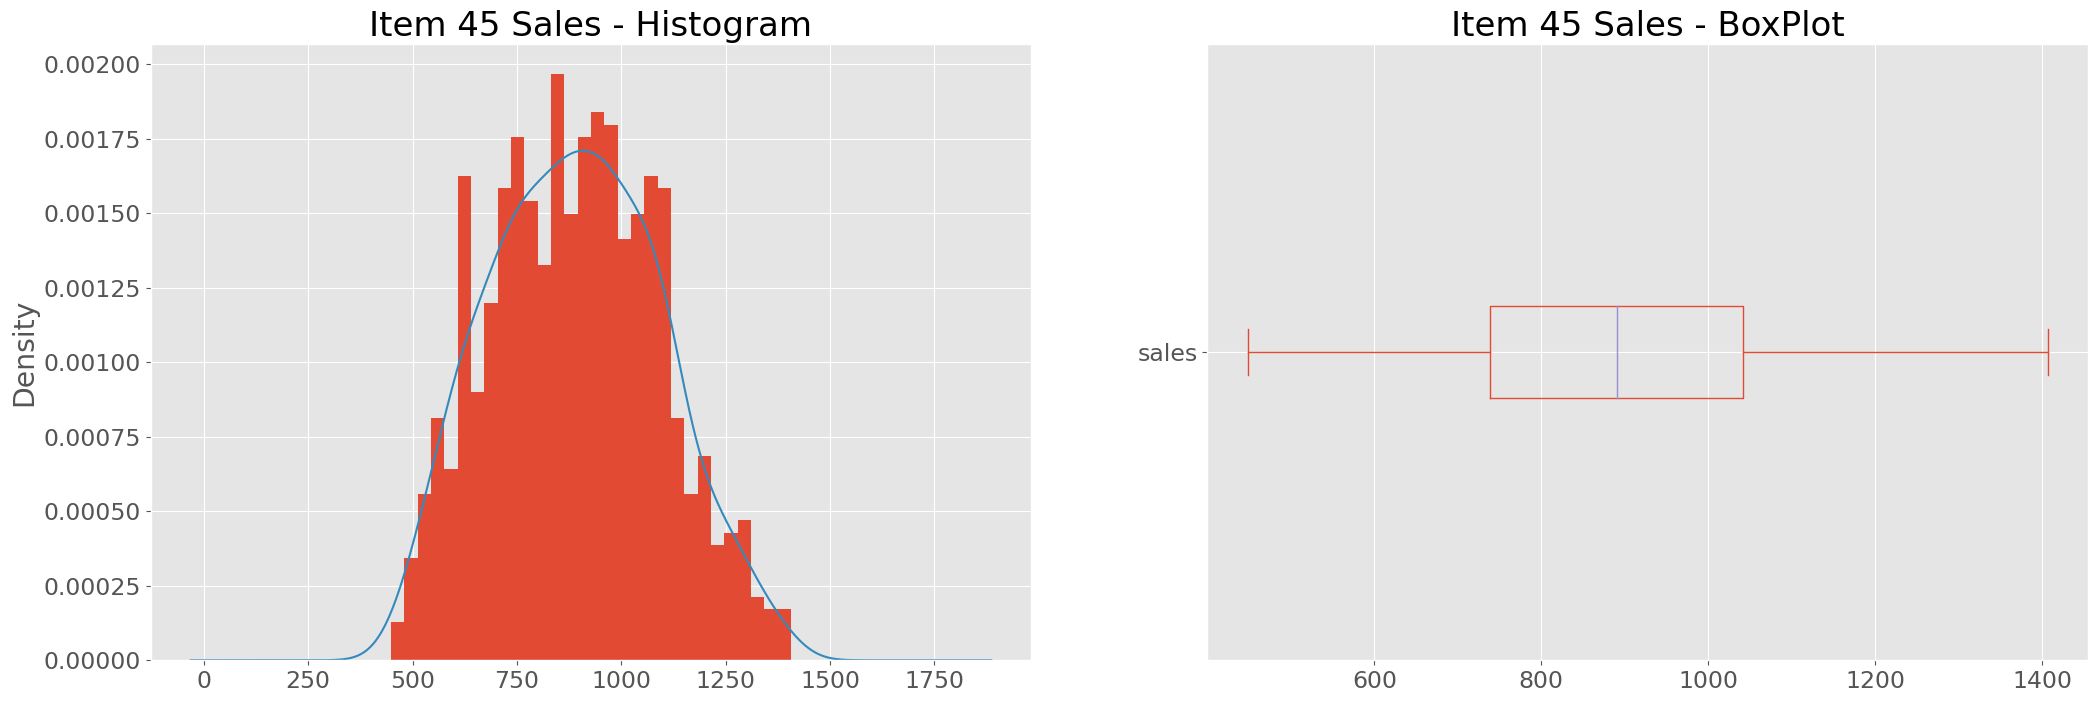

In [203]:
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)

In [204]:
test_normality(daily_sales.sales)

p-value: 0.0000
Reject the null Hypothesis. We can't say it is normal distributed


### CLT

In [205]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

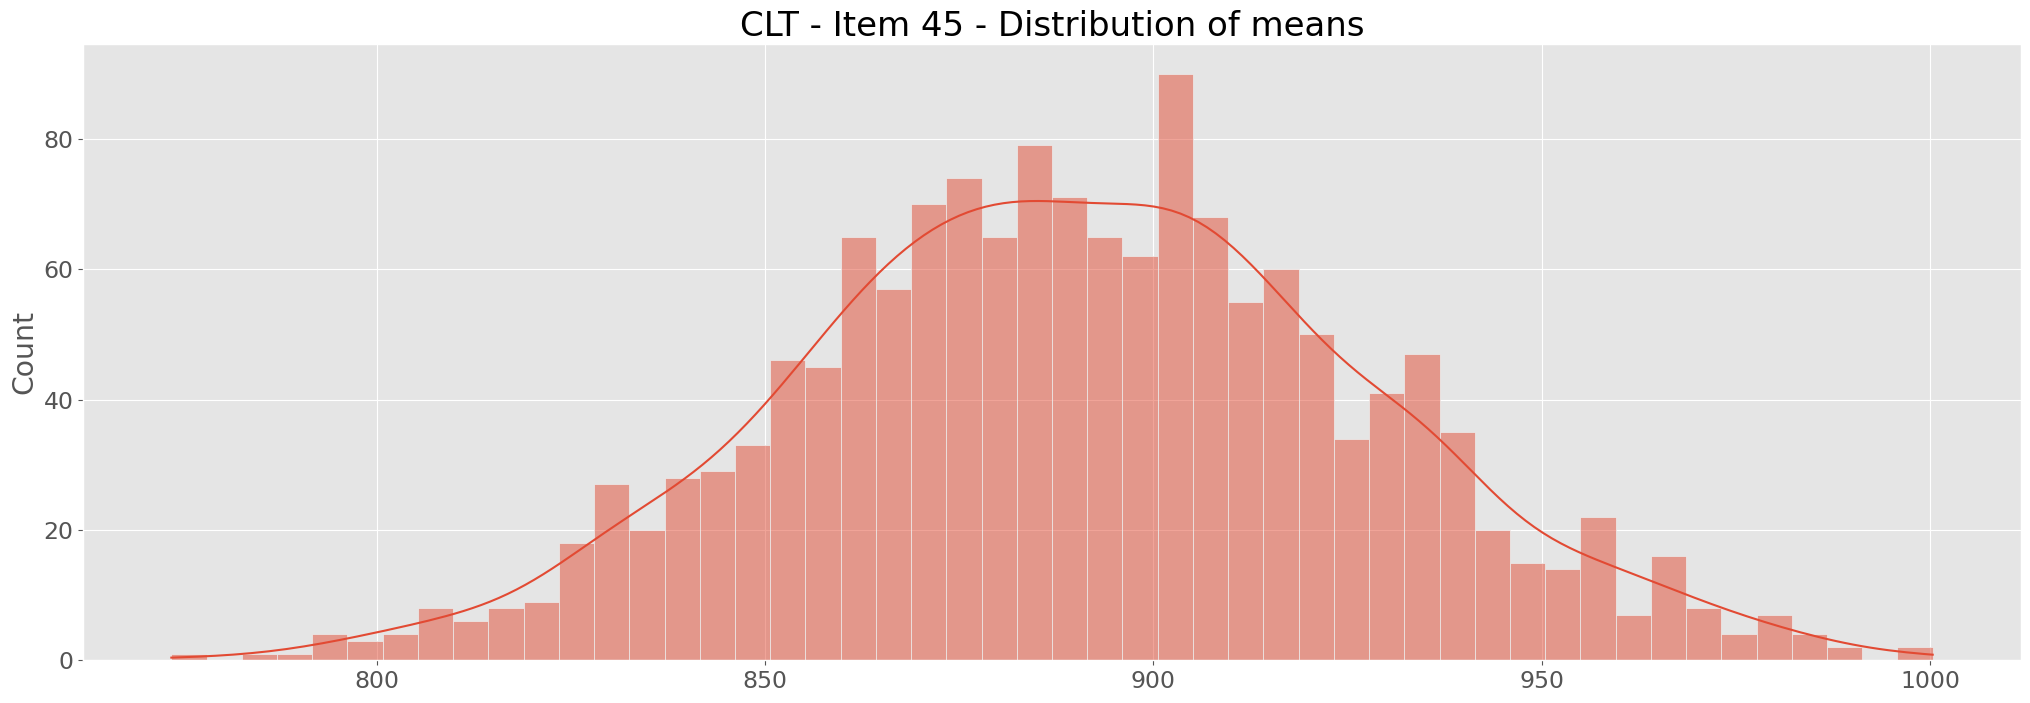

In [206]:
hist_means(samples_means, product=product);

In [207]:
test_normality(samples_means)

p-value: 0.6001
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [208]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 890.7004103967168
Sample mean: 890.7352666666666
Population standard deviation: 36.86526708632363
Sample standard deviation: 36.644756342119855


### 1. What is the probability that I will sell 950 units a day?

In [209]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [210]:
target_ = 950
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 950 units or more is 5.29%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [211]:
target_ = 1000
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 1000 units every day is 0.14%


### 3. What is the range which contains 90% of my possible demand?

In [212]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [830    ———    951]


### 4. How much stock should I have if I want 80% probability of stocking out?

In [213]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 922 units in your stock if you want a 20.0% probability of stocking out.


## 4.7 Item 38

In [214]:
product = class_a_items[6]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')

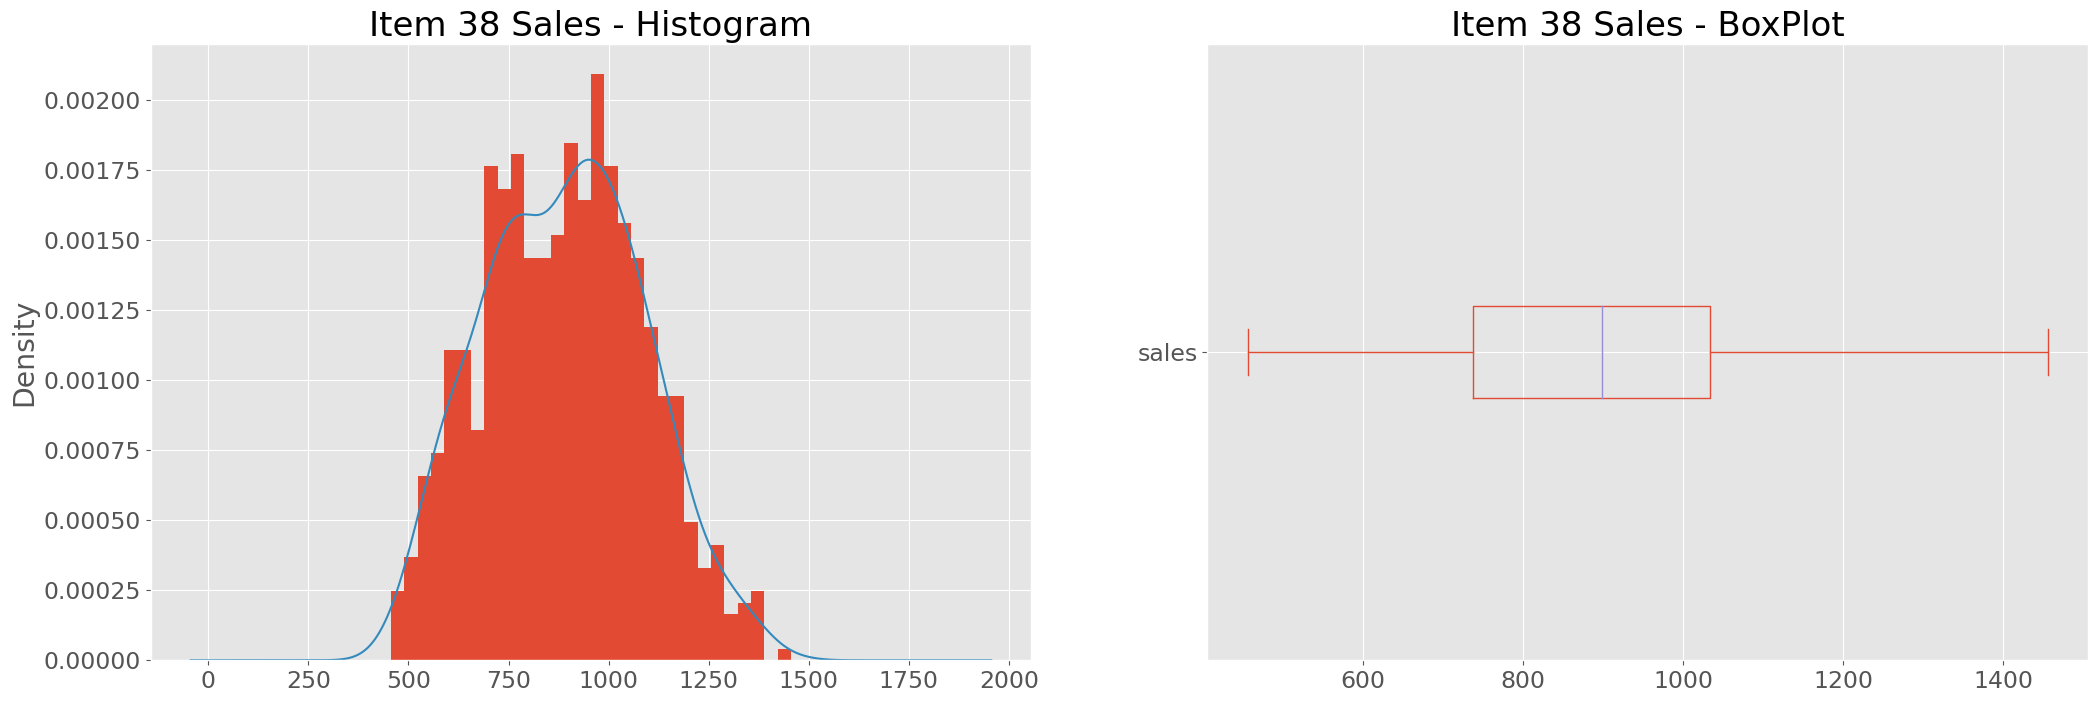

In [215]:
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)

In [216]:
test_normality(daily_sales.sales)

p-value: 0.0001
Reject the null Hypothesis. We can't say it is normal distributed


### CLT

In [217]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

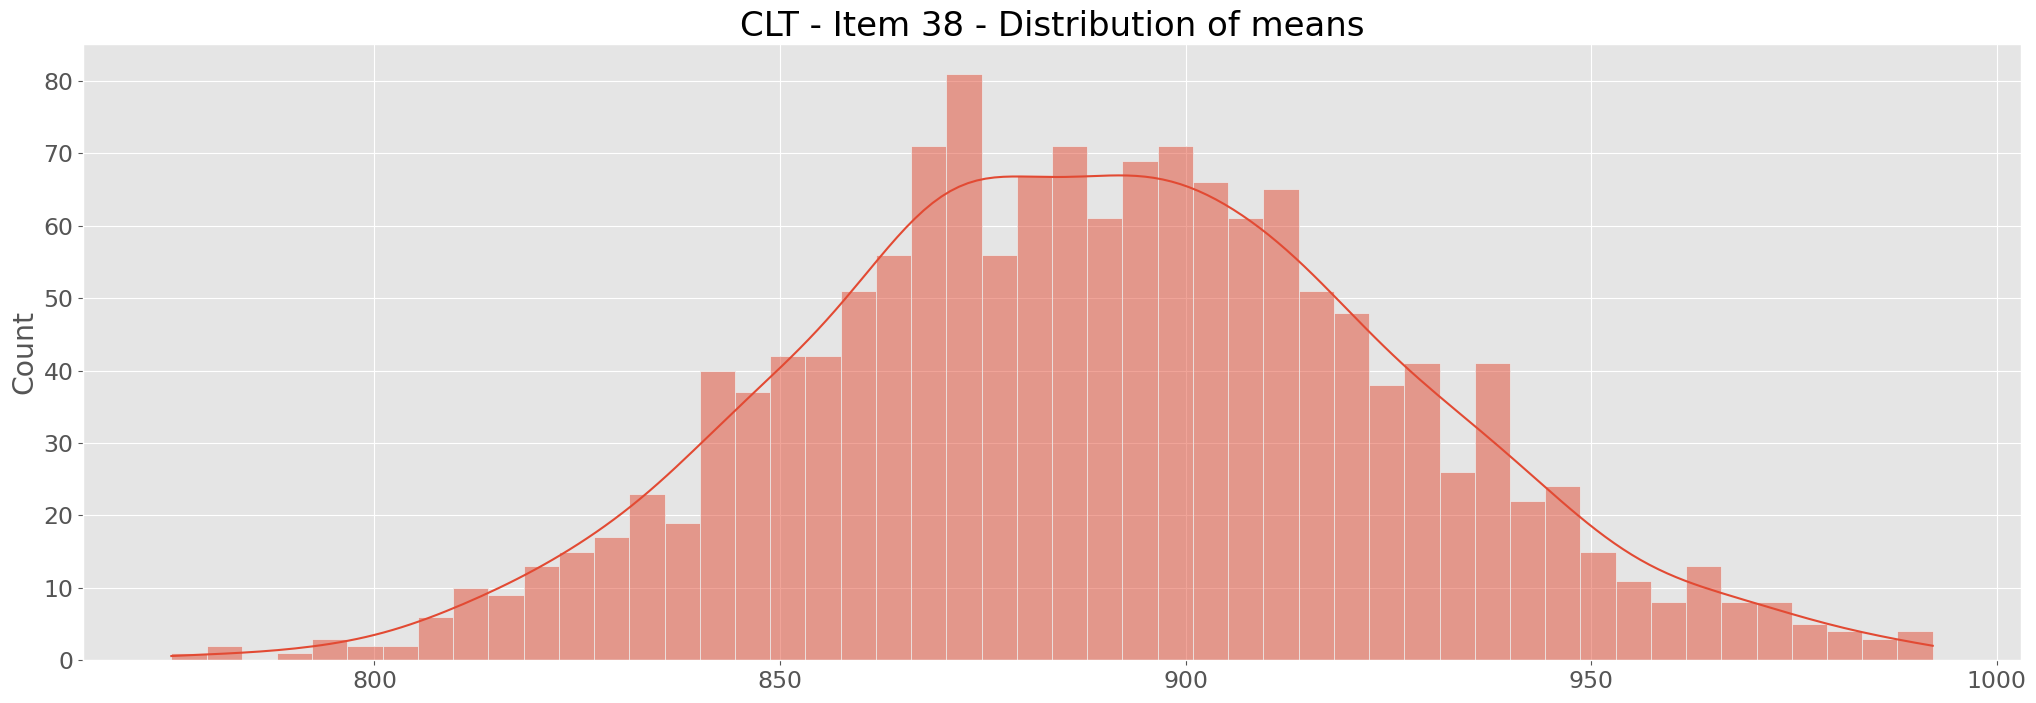

In [218]:
hist_means(samples_means, product=product);

In [219]:
test_normality(samples_means)

p-value: 0.3475
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [220]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 889.3228454172366
Sample mean: 889.4277111111113
Population standard deviation: 36.359361760101024
Sample standard deviation: 36.447153893124984


### 1. What is the probability that I will sell 950 units a day?

In [221]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [222]:
target_ = 950
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 950 units or more is 4.83%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [228]:
target_ = 1000
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 1000 units every day is 0.12%


### 3. What is the range which contains 90% of my possible demand?

In [226]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [829    ———    949]


### 4. How much stock should I have if I want 80% probability of stocking out?

In [227]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 920 units in your stock if you want a 20.0% probability of stocking out.


## 4.8 Item 22

In [229]:
product = class_a_items[7]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')

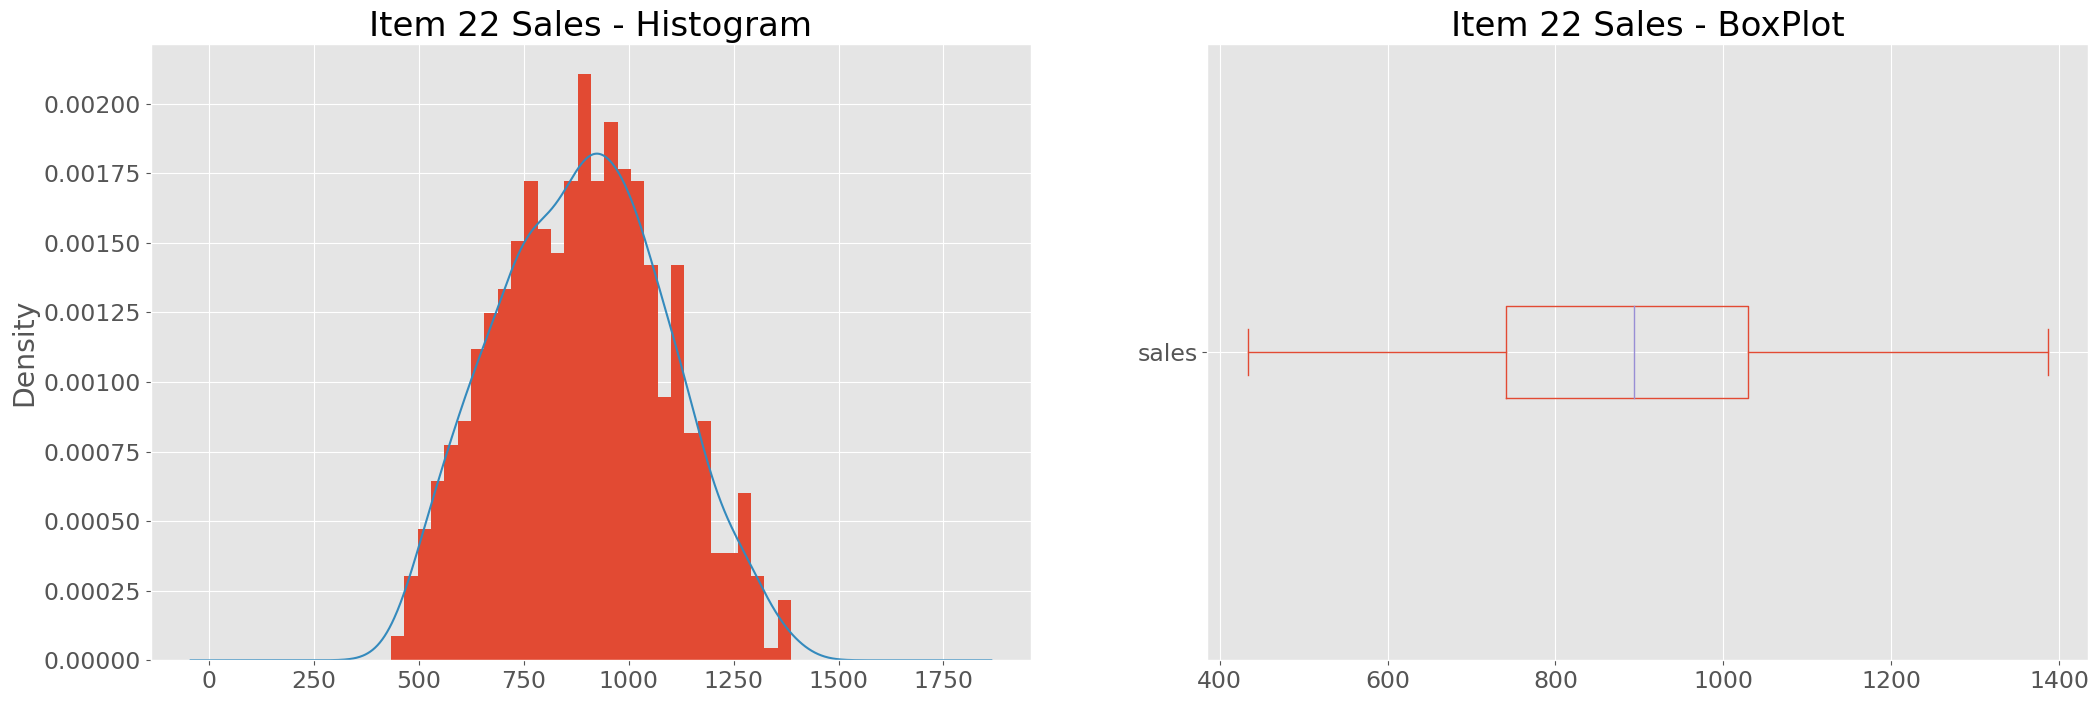

In [230]:
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)

In [231]:
test_normality(daily_sales.sales)

p-value: 0.0000
Reject the null Hypothesis. We can't say it is normal distributed


### CLT

In [232]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

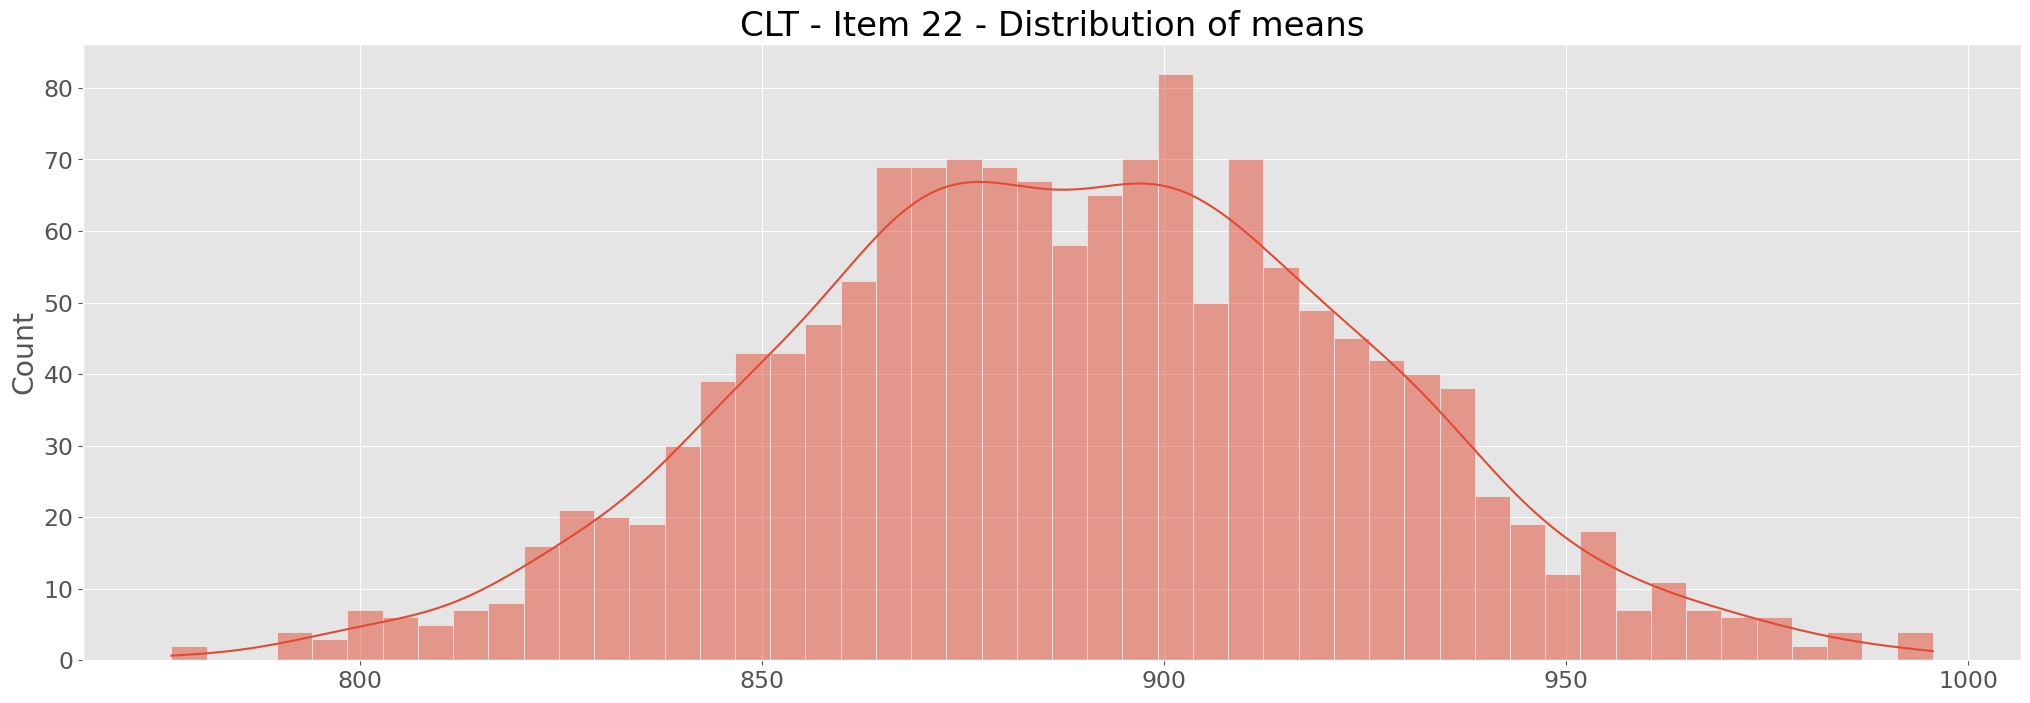

In [233]:
hist_means(samples_means, product=product);

In [234]:
test_normality(samples_means)

p-value: 0.6258
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [235]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 888.3912448700411
Sample mean: 888.5972222222223
Population standard deviation: 36.221222936956856
Sample standard deviation: 36.35711240808765


### 1. What is the probability that I will sell 950 units a day?

In [237]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [238]:
target_ = 950
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 950 units or more is 4.56%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [239]:
target_ = 1000
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 1000 units every day is 0.11%


### 3. What is the range which contains 90% of my possible demand?

In [240]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [829    ———    948]


### 4. How much stock should I have if I want 80% probability of stocking out?

In [241]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 919 units in your stock if you want a 20.0% probability of stocking out.


## 4.9 Item 8

In [242]:
product = class_a_items[8]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')

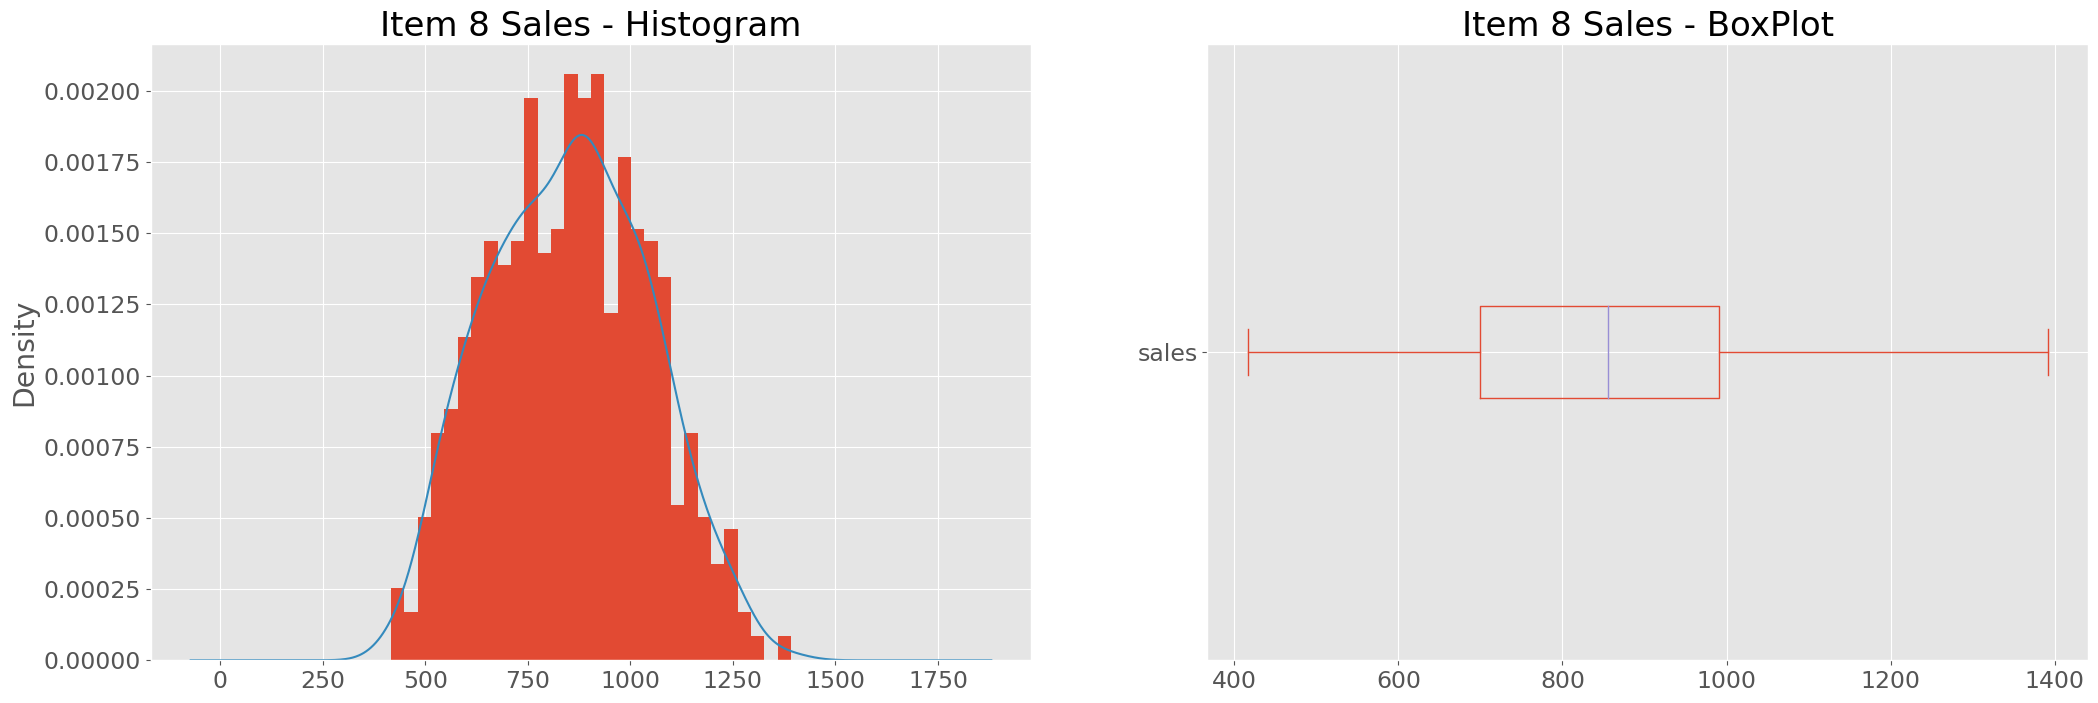

In [243]:
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)

In [244]:
test_normality(daily_sales.sales)

p-value: 0.0000
Reject the null Hypothesis. We can't say it is normal distributed


### CLT

In [245]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

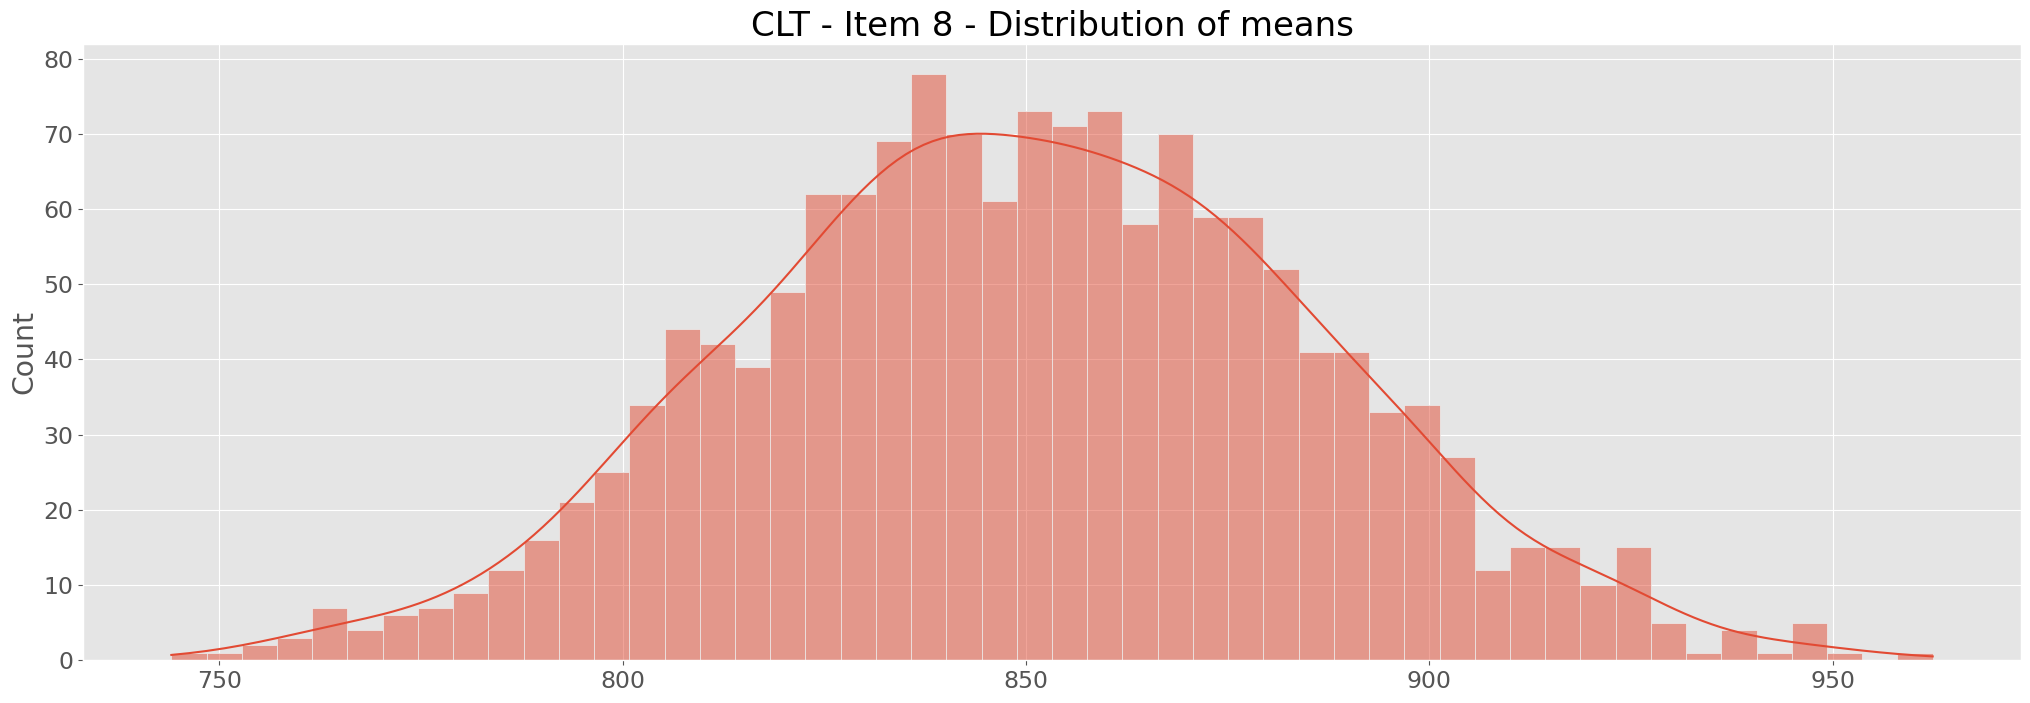

In [246]:
hist_means(samples_means, product=product);

In [247]:
test_normality(samples_means)

p-value: 0.3726
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [248]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 850.4035567715458
Sample mean: 850.5216666666666
Population standard deviation: 35.3033390938578
Sample standard deviation: 35.23720797837296


### 1. What is the probability that I will sell 920 units a day?

In [250]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [252]:
target_ = 920
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 920 units or more is 2.43%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [254]:
target_ = 900
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 900 units every day is 8.01%


### 3. What is the range which contains 90% of my possible demand?

In [255]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [793    ———    908]


### 4. How much stock should I have if I want 80% probability of stocking out?

In [256]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 880 units in your stock if you want a 20.0% probability of stocking out.


## 4.10 Item 36

In [257]:
product = class_a_items[9]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')

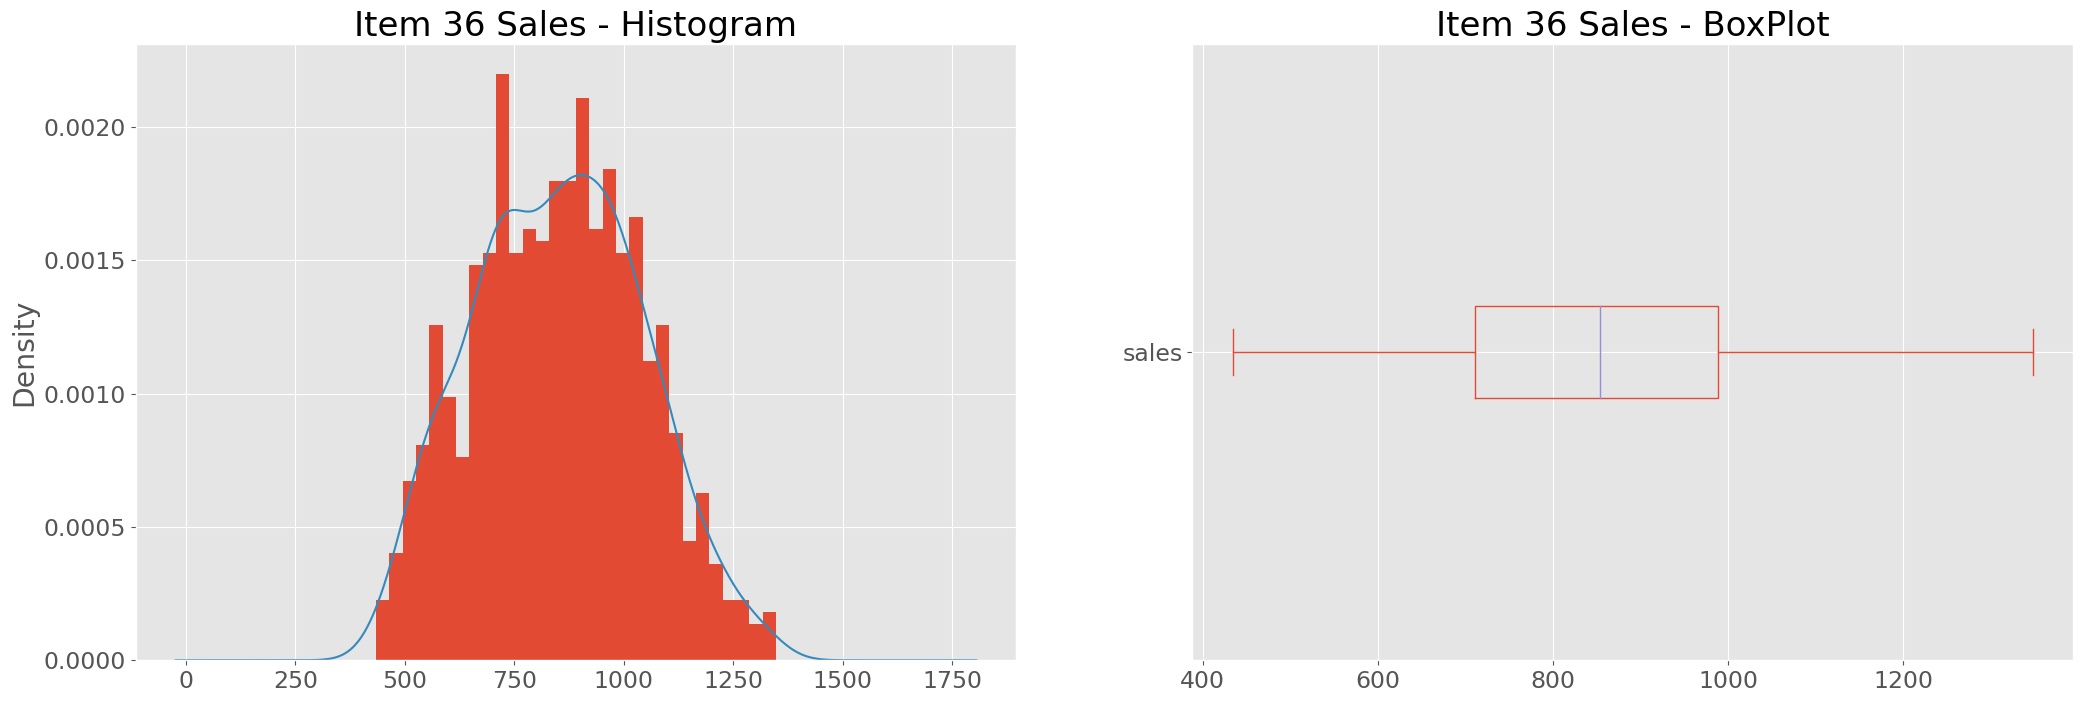

In [258]:
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)

In [259]:
test_normality(daily_sales.sales)

p-value: 0.0000
Reject the null Hypothesis. We can't say it is normal distributed


### CLT

In [260]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

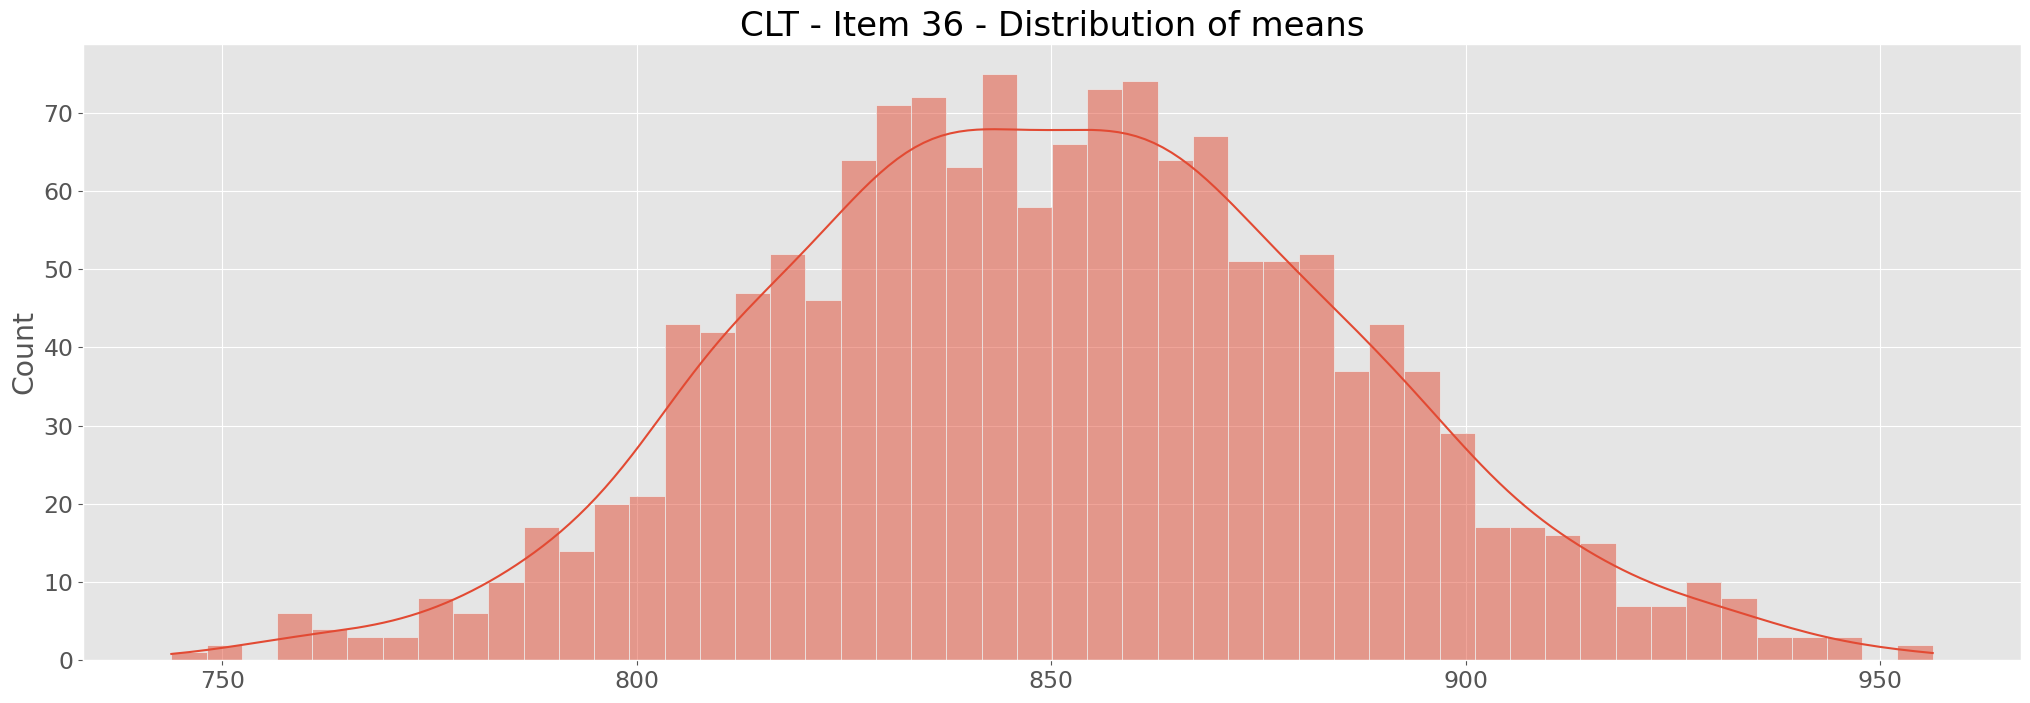

In [261]:
hist_means(samples_means, product=product);

In [262]:
test_normality(samples_means)

p-value: 0.4234
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [263]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 850.3720930232558
Sample mean: 850.4383777777778
Population standard deviation: 34.91141090599723
Sample standard deviation: 34.842968137454285


### 1. What is the probability that I will sell 920 units a day?

In [265]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [266]:
target_ = 920
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 920 units or more is 2.29%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [267]:
target_ = 900
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 900 units every day is 7.75%


### 3. What is the range which contains 90% of my possible demand?

In [268]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [793    ———    908]


### 4. How much stock should I have if I want 80% probability of stocking out?

In [269]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 880 units in your stock if you want a 20.0% probability of stocking out.


## 4.11 Item 10

In [270]:
product = class_a_items[10]
daily_sales = prod_daily_sales(data=sales_df, product=product, target='sales', date_col='date')

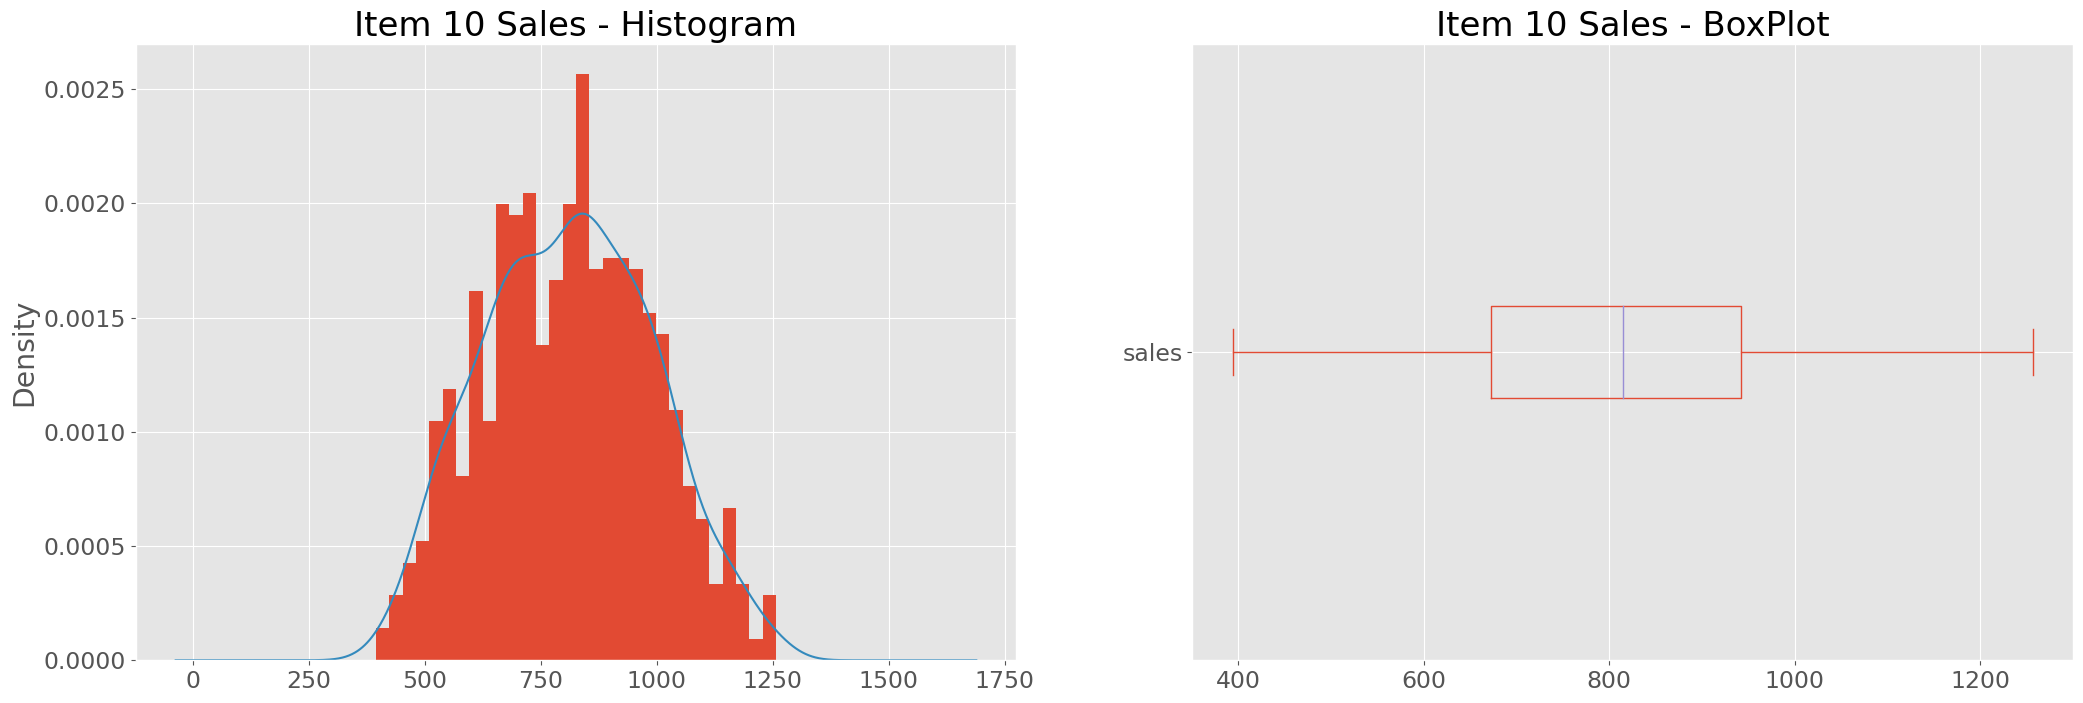

In [271]:
hist_box(data=daily_sales, attribute='sales', bins=30, product=product)

In [272]:
test_normality(daily_sales.sales)

p-value: 0.0000
Reject the null Hypothesis. We can't say it is normal distributed


### CLT

In [273]:
samples, samples_means = sampling(data=daily_sales, n_samples=1500, sample_size=30, attribute='sales')

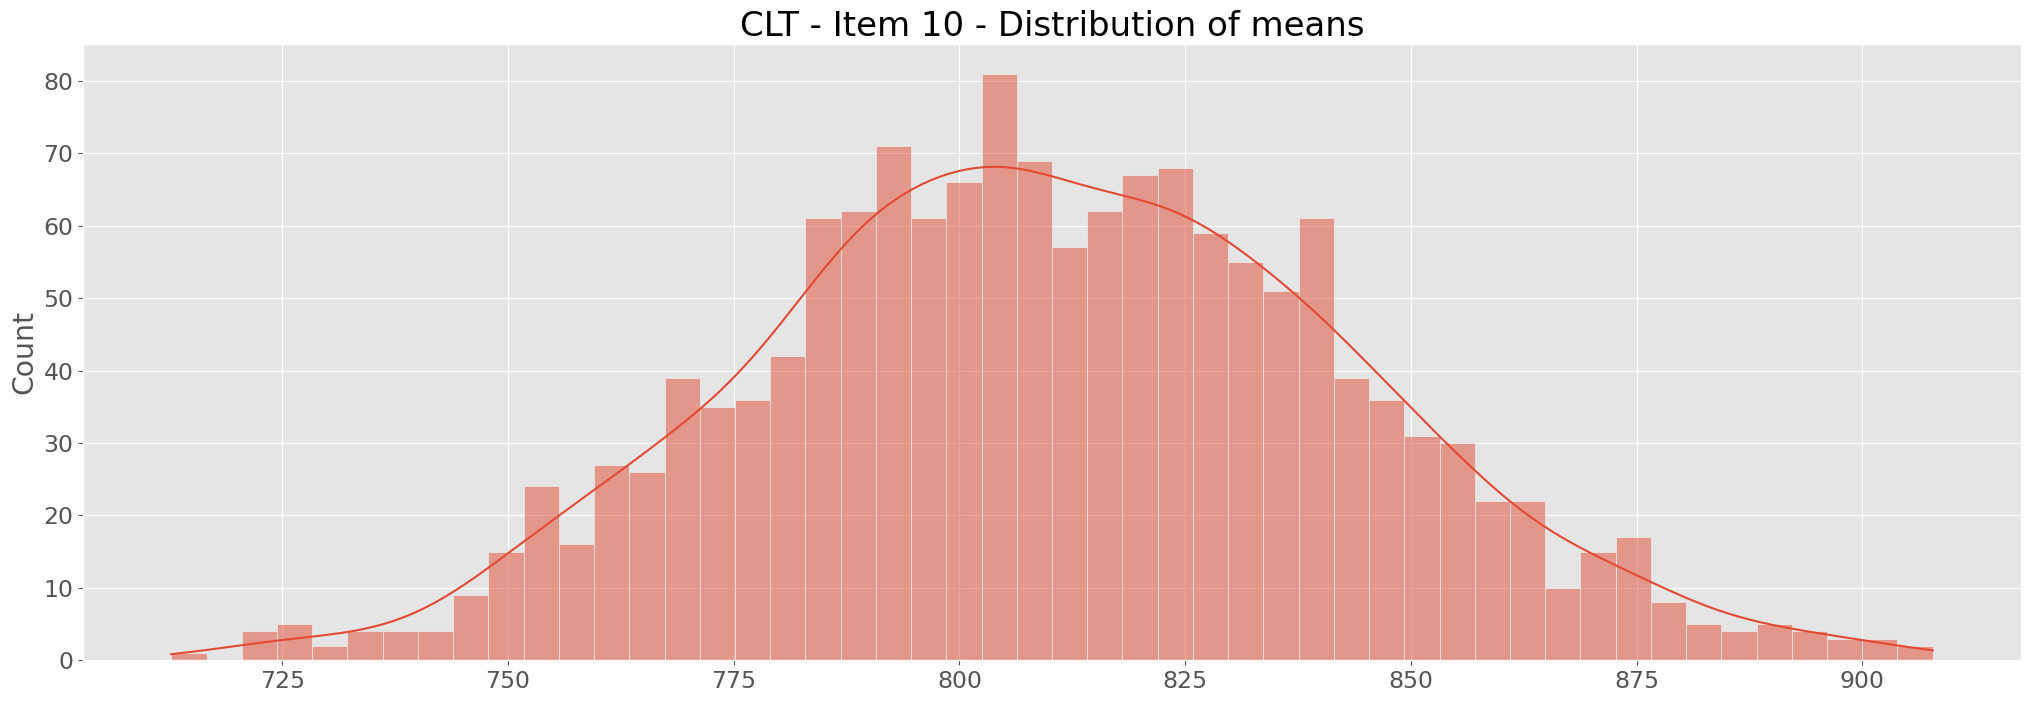

In [274]:
hist_means(samples_means, product=product);

In [275]:
test_normality(samples_means)

p-value: 0.2757
Fail to reject the null Hypothesis. We can't say the data it is not normal distributed


In [276]:
print(f'Population mean: {daily_sales.sales.mean()}\nSample mean: {np.mean(samples_means)}')
print(f'Population standard deviation: {daily_sales.sales.std()/np.sqrt(30)}\nSample standard deviation: {np.std(samples_means)}')

Population mean: 810.3625170998632
Sample mean: 810.5593555555555
Population standard deviation: 32.962526760780705
Sample standard deviation: 32.84018032204895


### 1. What is the probability that I will sell 850 units a day?

In [280]:
avg = np.mean(samples_means)
stand = np.std(samples_means)

In [281]:
target_ = 850
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of selling {target_} units or more is {prob:.2%}')

The probability of selling 850 units or more is 11.49%


### 2. Given the demand, what is the probability of stock-out if I arrange to have 1000 units in stock every day?

In [283]:
target_ = 900
prob = probability_sale_at_least(target_, avg, stand)

print(f'The probability of stocking out if you arrange to have {target_} units every day is {prob:.2%}')

The probability of stocking out if you arrange to have 900 units every day is 0.32%


### 3. What is the range which contains 90% of my possible demand?

In [284]:
lw, up = interval_perc(mean=avg, st_dev=stand, percent=0.90)

Range with 90.00% of possible demand:
Lower Limit  ——— Upper Limit
     [757    ———    865]


### 4. How much stock should I have if I want 80% probability of stocking out?

In [285]:
proba = 0.2
result = stocking_out_value(avg, stand, proba)

print(f'You should have {result} units in your stock if you want a {proba:.1%} probability of stocking out.')

You should have 838 units in your stock if you want a 20.0% probability of stocking out.


## 4.12 Item 11

## 4.13 Item 29

## 4.14 Item 12

## 4.15 Item 33

## 4.16 Item 24

## 4.17 Item 50

## 4.18 Item 35

## 4.19 Item 14

## 4.20 Item 46 

## 4.21 Item 31

## 4.22 Item 2

## 4.23 Item 6

## 4.24 Item 7

## 4.25 Item 48

## 4.26 Item 43